In [2]:
from PhasePicker import PickerNet
from PhasePickerTraining import Picker
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import os
from PhaseNetPicker import PhaseNetPicker
from SWAG import SWAGInference
import h5py
os.chdir("/Users/noahliniger/Documents/GitHub/earthquake-monitoring")
from models.PhaseNet import PhaseNetL
from tqdm import tqdm
import matplotlib.colors as colors



# Loading the model, dataloaders etc.

In [3]:
checkpoint = torch.load('/Users/noahliniger/Documents/GitHub/earthquake-monitoring/ContinuedTraining.pth')
model = PhaseNetPicker()
model.load_state_dict(checkpoint['model_state'])
csv_files = ['/Users/noahliniger/Downloads/chunk2/chunk2.csv', '/Users/noahliniger/Downloads/chunk3/chunk3.csv', '/Users/noahliniger/Downloads/chunk4/chunk4.csv',\
                '/Users/noahliniger/Downloads/chunk5/chunk5.csv', '/Users/noahliniger/Downloads/chunk6/chunk6.csv'] 
h5_files = ['/Users/noahliniger/Downloads/chunk2/chunk2.hdf5', '/Users/noahliniger/Downloads/chunk3/chunk3.hdf5', '/Users/noahliniger/Downloads/chunk4/chunk4.hdf5',\
                '/Users/noahliniger/Downloads/chunk5/chunk5.hdf5', '/Users/noahliniger/Downloads/chunk6/chunk6.hdf5'] 
picker = Picker(csv_files=csv_files, h5_files=h5_files, model=model)
print("Creating the data loaders...")
train_loader, test_loader, valid_loader = picker.createDataLoaders(frac_train=0.7, frac_test=0.15, batch_size=32, return_snr=False, input_length=5864)
print("Created the data loaders...")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

#classifier = torch.load('/Users/noahliniger/Documents/GitHub/earthquake-monitoring/classification_tolga/phasenet_15epochs.pt')
#classifier.to(device)

Device: mps
Creating the data loaders...
Created the data loaders...


PhaseNetPicker(
  (inc): Conv1d(1, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
     

In [4]:
#Wrapper around the classifier:
# class MyModelWrapper(nn.Module):
#     def __init__(self, model, device):
#         super(MyModelWrapper, self).__init__()
#         self.model = model
#         self.model.to(device)

#     def forward(self, x):
#         x = x.squeeze(1)
#         output = self.model(x)  # Assuming output shape is [32, 3, 5864]
#         final_output = torch.zeros(output.size(0), 2)
#         final_output[:,0] = torch.argmax(output[:,0,:], dim=1)
#         final_output[:,1] = torch.argmax(output[:,1,:], dim=1)
#         return final_output

# MaxRegressor = MyModelWrapper(classifier, device=device).to(device)

In [5]:
# Plotting function:
def plotPredictions(waves, predictions, labels, min: int = 100, max: int = 5000):

    x = np.linspace(start=min, stop=max, num=max-min)

    for i in range(32):
        # Creating the primary axis for the wave and vertical lines
        fig, ax1 = plt.subplots(figsize=(20, 6))

        # Plotting the wave
        ax1.plot(x, waves[i,0,min:max], 'k')
        ax1.set_xlabel('Time (s)', fontsize=16)
        ax1.set_ylabel('Density', color='k', fontsize=16)
        ax1.tick_params(axis='both', which='major', labelsize=14)

        #P wave
        map_value = np.mean(predictions[:,i,0])
        stdP = np.std(predictions[:,i,0])
        true_label = labels[i,0]

        ax1.vlines(map_value, ymax=1, ymin=0, colors="r", label="Mean Prediction P", linewidth=3) #linestyles="--")
        ax1.vlines(true_label, ymax=1, ymin=0, colors="b", label="True P", linewidth=3) #linestyles="--")

        ax1.vlines(map_value + stdP, ymax=1, ymin=0, colors="gray", label="$\pm$ Standard Deviation", linewidth=3, linestyles="--")
        ax1.vlines(map_value - stdP, ymax=1, ymin=0, colors="gray", linewidth=3, linestyles="--")


        #S wave
        map_value = np.mean(predictions[:,i,1])
        stdS = np.std(predictions[:,i,1])
        true_label = labels[i,1]

        ax1.vlines(map_value, ymax=1, ymin=0, colors="g", label="Mean Prediction S",linewidth=3) #linestyles="--")
        ax1.vlines(true_label, ymax=1, ymin=0, colors="orange", label="True S", linewidth=3) #linestyles="--") 

        ax1.vlines(map_value + stdS, ymax=1, ymin=0, colors="pink", linewidth=3, linestyles="--")
        ax1.vlines(map_value - stdS, ymax=1, ymin=0, colors="pink", linewidth=3, linestyles="--")

        ax1.hist(predictions[:,i,0], bins=2, alpha=0.5, color='gray', density=True)
        ax1.hist(predictions[:,i,1], bins=2, alpha=0.5, color='pink', density=True)


        # Adding legend and showing the plot
        ax1.legend(fontsize=14)
        fig.tight_layout()
        plt.show()

# SWAG Evaluation

In [6]:
def plotResiduals(difference):
    mean_p = np.mean(difference[:,0]/100)
    std_dev_p = np.std(difference[:,0]/100)
    mean_s = np.mean(difference[:,1]/100)
    std_dev_s = np.std(difference[:,1]/100)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Blue color scheme for the first subplot
    axs[0].hist(difference[:,0]/100, bins=30, density=True, range=(-3, 3), alpha=0.8, color='lightblue', edgecolor='black')
    axs[0].axvline(mean_p, color='red', linestyle='dashed', linewidth=2)
    axs[0].axvline(mean_p - std_dev_p, color='navy', linestyle='dashed', linewidth=2)
    axs[0].axvline(mean_p + std_dev_p, color='navy', linestyle='dashed', linewidth=2)
    axs[0].set_xlabel("Residual P")
    axs[0].set_ylabel("Histogram Density")

    # Blue color scheme for the second subplot
    line_mean = axs[1].axvline(mean_s, color='red', linestyle='dashed', linewidth=2, label='Mean')
    line_std_neg = axs[1].axvline(mean_s - std_dev_s, color='navy', linestyle='dashed', linewidth=2, label='Std Dev')
    line_std_pos = axs[1].axvline(mean_s + std_dev_s, color='navy', linestyle='dashed', linewidth=2)
    axs[1].hist(difference[:,1]/100, bins=30, density=True, range=(-3, 3), alpha=0.7, color='lightblue', edgecolor='black')
    axs[1].set_xlabel("Residual S")
    axs[1].legend()

    # Adjusting the 2D histogram to a blue color scheme
    h = axs[2].hist2d(difference[:,1]/100, difference[:,0]/100, bins=(1000, 1000), cmap='Blues', norm=colors.LogNorm(), density=True)
    cb = fig.colorbar(h[3], ax=axs[2])
    axs[2].set_xlim(-3, 3)
    axs[2].set_ylim(-3, 3)
    axs[2].set_xlabel("Residual S")
    axs[2].set_ylabel("Residual P")
    cb.set_label("Histogram Density (Log Scale)", rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

In [7]:
# Read in the files with the predictions:
for i in range(100):
    globals()['pred%s' % i] = torch.load(f"/Users/noahliniger/Documents/GitHub/earthquake-monitoring/Regression/SwagPredictions/100Samples_WholeValid_{i}.pt").cpu().detach().numpy()
stacked = np.stack([globals()['pred' + str(i)] for i in range(100)])


In [13]:
# import itertools

# means = np.mean(stacked, axis = 0)
# stds = np.std(stacked, axis=0)

# difference = np.zeros_like(means)
# true_labels = np.zeros_like(means)
# processed_samples = 0
# half_batch_count = len(valid_loader) // 2
# # Create an iterator that iterates over the first half of the batches
# half_test_loader = itertools.islice(valid_loader, half_batch_count)
# for waves, labels in tqdm(half_test_loader):
#     labels = labels.numpy()
#     difference[processed_samples:(processed_samples+labels.shape[0]),:] = means[processed_samples:(processed_samples+labels.shape[0]),:] - labels
#     true_labels[processed_samples:(processed_samples+labels.shape[0]),:] = labels
#     processed_samples += labels.shape[0]


In [14]:
difference = np.load("/Users/noahliniger/Documents/GitHub/earthquake-monitoring/Regression/SwagPredictions/difference.npy")
means = np.load("/Users/noahliniger/Documents/GitHub/earthquake-monitoring/Regression/SwagPredictions/means.npy")
stds = np.load("/Users/noahliniger/Documents/GitHub/earthquake-monitoring/Regression/SwagPredictions/stds.npy")
true_labels = np.load("/Users/noahliniger/Documents/GitHub/earthquake-monitoring/Regression/SwagPredictions/true_labels.npy")

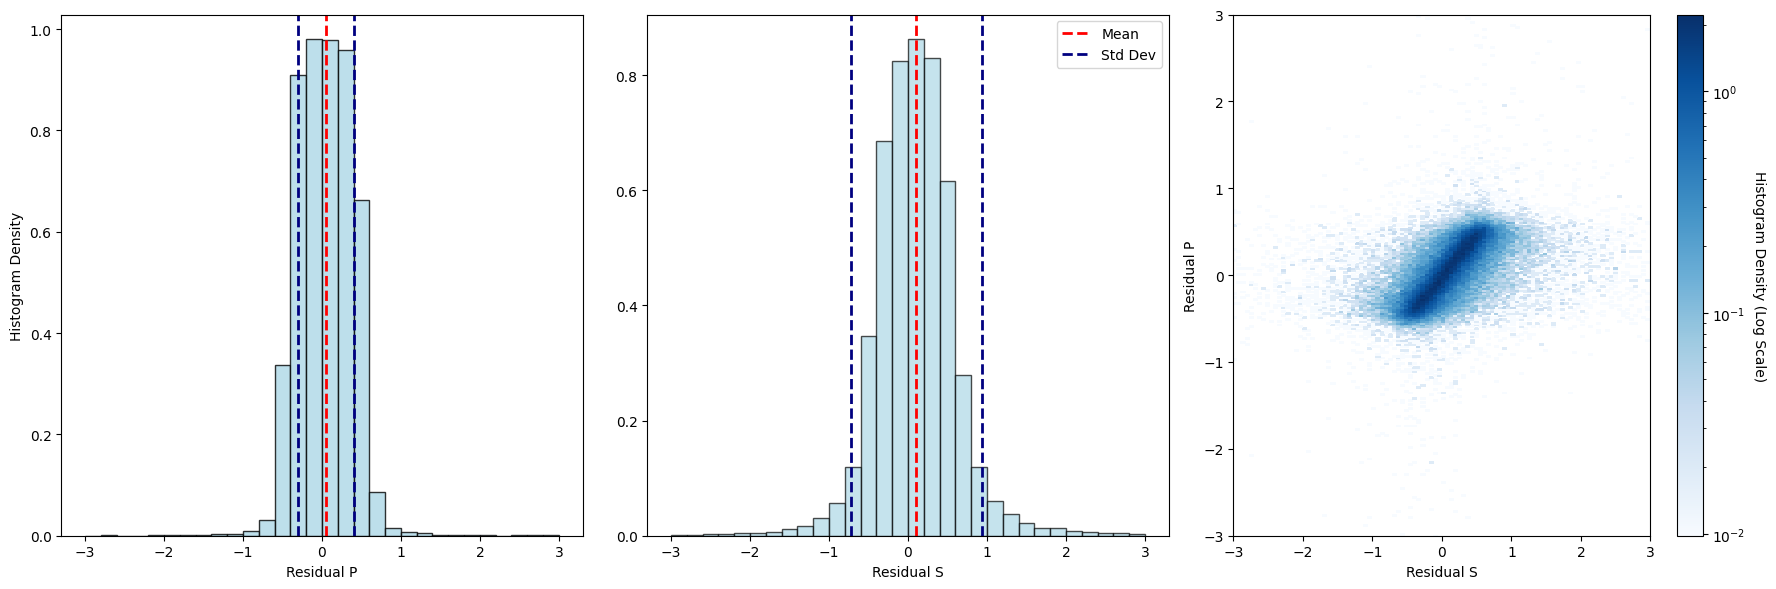

In [15]:
plotResiduals(difference)

In [16]:
print(stacked.shape)

(100, 77280, 2)


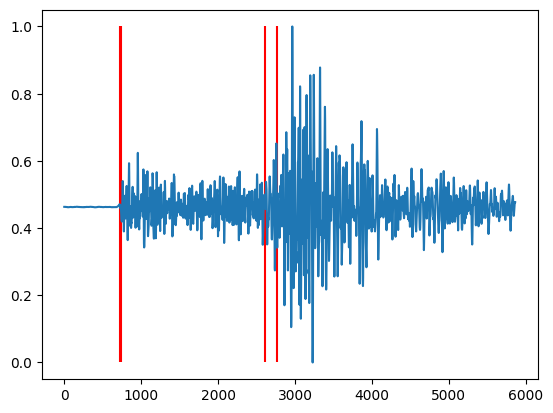

(array([ 5., 16., 10.,  6.,  9., 16., 11., 14.,  9.,  4.]),
 array([597.7689 , 609.1242 , 620.4795 , 631.8348 , 643.19006, 654.5453 ,
        665.9006 , 677.25586, 688.61115, 699.96643, 711.3217 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

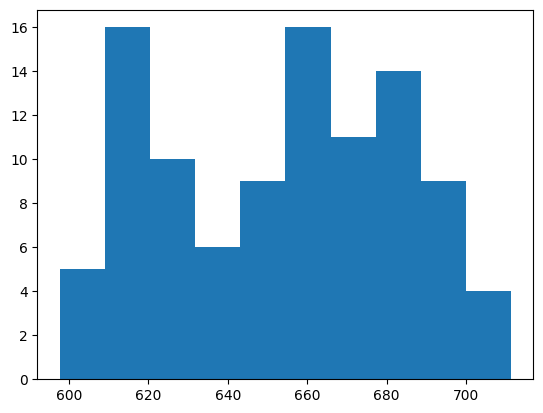

In [17]:
plt.plot(waves[31,0,:])
plt.vlines(labels[-1,0], ymin=0,ymax=1, colors='r')
plt.vlines(labels[-1,1],ymin=0,ymax=1, colors='r')
plt.vlines(means[-1,0],ymin=0,ymax=1, colors='r')
plt.vlines(means[-1,1],ymin=0,ymax=1, colors='r')
plt.show()
plt.hist(stacked[:,5,0])

In [264]:
# Copyright (C) 2021-2023 Ruhr West University of Applied Sciences, Bottrop, Germany
# AND e:fs TechHub GmbH, Gaimersheim, Germany
#
# This Source Code Form is subject to the terms of the Apache License 2.0
# If a copy of the APL2 was not distributed with this
# file, You can obtain one at https://www.apache.org/licenses/LICENSE-2.0.txt.

from typing import Union, Iterable, Tuple, List
import numpy as np
from matplotlib import pyplot as plt

from netcal import is_in_quantile


class ReliabilityRegression(object):
    """
    Reliability diagram in the scope of regression calibration for probabilistic regression models.
    This diagram visualizes the quantile coverage frequency for several quantile levels and plots these observed
    coverage scores above the desired quantile levels.
    In this way, it is possible to compare the predicted and the observed quantile levels with each other.

    This method is able to visualize the quantile coverage in terms of multiple univariate distributions if the input
    is given as multiple independent Gaussians.
    This method is also able to visualize the multivariate quantile coverage for a joint multivariate Gaussian if the
    input is given with covariance matrices.

    Parameters
    ----------
    quantiles : int or iterable, default: 11
        Quantile levels that are used for the visualization of the regression reliability diagram.
        If int, use NumPy's linspace method to get the quantile levels.
        If iterable, use the specified quantiles for visualization.
    """

    eps = np.finfo(np.float32).eps

    def __init__(self, quantiles: Union[int, Iterable[float], np.ndarray] = 11):
        """ Constructor. For detailed parameter documentation view classdocs. """

        # init list of quantiles if input type is int
        if isinstance(quantiles, int):
            self.quantiles = np.clip(np.linspace(0., 1., quantiles), self.eps, 1.-self.eps)

        # use input list or array as quantile list
        elif isinstance(quantiles, (list, np.ndarray)):

            # at this point, allow for 0 and 1 quantile to be aligned on the miscalibration curve
            assert (quantiles >= 0).all(), "Found quantiles <= 0."
            assert (quantiles <= 1).all(), "Found quantiles >= 1."
            self.quantiles = np.clip(np.array(quantiles), self.eps, 1.-self.eps)

        else:
            raise AttributeError("Unknown type \'%s\' for param \'quantiles\'." % type(quantiles))

    def plot(
            self,
            X: Union[Tuple[np.ndarray, np.ndarray], np.ndarray],
            y: np.ndarray,
            *,
            kind: str = 'meanstd',
            filename: str = None,
            tikz: bool = False,
            title_suffix: str = None,
            feature_names: List[str] = None,
            fig: plt.Figure = None,
            **save_args
    ) -> Union[plt.Figure, str]:
        """
        Reliability diagram for regression calibration to visualize the predicted quantile levels vs. the actually
        observed quantile coverage probability.
        This method is able to visualize the reliability diagram in terms of multiple univariate distributions if the
        input is given as multiple independent Gaussians.
        This method is also able to visualize the joint multivariate quantile calibration for a multivariate Gaussian
        if the input is given with covariance matrices (see parameter "kind" for a detailed description of the input
        format).

        Parameters
        ----------
        X : np.ndarray of shape (r, n, [d]) or (t, n, [d]), or Tuple of two np.ndarray, each of shape (n, [d])
            Input data obtained by a model that performs inference with uncertainty.
            See parameter "kind" for input format descriptions.
        y : np.ndarray of shape (n, [d])
            Target scores for each prediction estimate in X.
        kind : str, either "meanstd" or "cumulative"
            Specify the kind of the input data. Might be one of:
            - meanstd: if X is tuple of two NumPy arrays with shape (n, [d]) and (n, [d, [d]]), this method asserts the
                       first array as mean and the second one as the according stddev predictions for d dimensions.
                       If the second NumPy array has shape (n, d, d), this method asserts covariance matrices as input
                       for each sample. In this case, the NLL is calculated for multivariate distributions.
                       If X is single NumPy array of shape (r, n), this methods asserts predictions obtained by a stochastic
                       inference model (e.g. network using MC dropout) with n samples and r stochastic forward passes. In this
                       case, the mean and stddev is computed automatically.
            - cumulative: assert X as tuple of two NumPy arrays of shape (t, n, [d]) with t points on the cumulative
                          for sample n (and optionally d dimensions).
        filename : str, optional, default: None
            Optional filename to save the plotted figure.
        tikz : bool, optional, default: False
            If True, use 'tikzplotlib' package to return tikz-code for Latex rather than a Matplotlib figure.
        title_suffix : str, optional, default: None
            Suffix for plot title.
        feature_names : list, optional, default: None
            Names of the additional features that are attached to the axes of a reliability diagram.
        fig: plt.Figure, optional, default: None
            If given, the figure instance is used to draw the reliability diagram.
            If fig is None, a new one will be created.
        **save_args : args
            Additional arguments passed to 'matplotlib.pyplot.Figure.savefig' function if 'tikz' is False.
            If 'tikz' is True, the argument are passed to 'tikzplotlib.get_tikz_code' function.

        Returns
        -------
        matplotlib.pyplot.Figure if 'tikz' is False else str with tikz code.
            Visualization of the quantile calibration either as Matplotlib figure or as string with tikz code.
        """

        assert kind in ['meanstd', 'cauchy', 'cumulative'], 'Parameter \'kind\' must be either \'meanstd\', or \'cumulative\'.'

        # get quantile coverage of input
        in_quantile, _, _, _, _ = is_in_quantile(X, y, self.quantiles, kind)  # (q, n, [d]), (q, n, d), (n, d), (n, d, [d])

        # get the frequency of which y is within the quantile bounds
        frequency = np.mean(in_quantile, axis=1)  # (q, [d])

        # make frequency array at least 2d
        if frequency.ndim == 1:
            frequency = np.expand_dims(frequency, axis=1)  # (q, d) or (q, 1)

        n_dims = frequency.shape[-1]

        # check feature names parameter
        if feature_names is not None:
            assert isinstance(feature_names, (list, tuple)), "Parameter \'feature_names\' must be tuple or list."
            assert len(feature_names) == n_dims, "Length of parameter \'feature_names\' must be equal to the amount " \
                                                 "of dimensions. Input with full covariance matrices is interpreted " \
                                                 "as n_features=1."

        # # initialize plot and create an own chart for each dimension
        # if fig is None:
        #     # Create a single row of subplots with n_dims columns
        #     fig, axes = plt.subplots(nrows=1, ncols=n_dims, figsize=(4 * n_dims, 4), squeeze=False)
        # else:
        #     # Add subplots to an existing figure, side by side
        #     axes = [fig.add_subplot(1, n_dims, idx) for idx in range(1, n_dims + 1)]

        # # The rest of your plotting code remains the same
        # for dim, ax in enumerate(axes.flat):  # Use axes.flat for iteration

        #     ax.plot(self.quantiles, frequency[:, dim], "o-")
        #     ax.plot([0, 1], [0, 1], color='red', linestyle='--')
        #     ax.set_xlim((0.0, 1.0))
        #     ax.set_ylim((0.0, 1.0))
        #     ax.set_xlabel('Expected quantile')
        #     ax.set_ylabel('Observed frequency')
        #     ax.legend(['Output', 'Perfect Calibration'])
        #     ax.grid(True)

        #     # Construct the title
        #     title = 'Reliability Regression Diagram'
        #     if title_suffix is not None:
        #         title = title + ' - ' + title_suffix
        #     if feature_names is not None:
        #         title = title + ' - ' + feature_names[dim]
        #     else:
        #         title = title + ' - dim %02d' % dim

        #     ax.set_title(title)

        # fig.tight_layout()

        # if tikz is true, create tikz code from matplotlib figure
        if tikz:

            # get tikz code for our specific figure and also pass filename to store possible bitmaps
            tikz_fig = tikzplotlib.get_tikz_code(fig, filepath=filename, **save_args)

            # close matplotlib figure when tikz figure is requested to save memory
            plt.close(fig)
            fig = tikz_fig

        # save figure either as matplotlib PNG or as tikz output file
        if filename is not None:
            if tikz:
                with open(filename, "w") as open_file:
                    open_file.write(fig)
            else:
                fig.savefig(filename, **save_args)

        return self.quantiles, frequency

In [265]:
from netcal.metrics import NLL, PinballLoss, QCE

quantiles = np.linspace(0.1, 0.9, 9)
means = np.mean(stacked, axis = 0)
stds = np.std(stacked, axis=0)

nll = NLL()
qce = QCE(marginal=True)
print(nll.measure((means, stds), true_labels, reduction="mean"))
print(qce.measure((means, stds), true_labels, q=quantiles, reduction="mean"))

5.4304557890720995
0.07353275247296989


In [266]:
diagram = ReliabilityRegression(quantiles=np.linspace(0.1,0.9,9))
quantiles, frequency = diagram.plot((means, stds), true_labels)

quantiles, frequency = diagram.plot(stacked.reshape(100,-1,2), true_labels.reshape(-1,2))

In [33]:
# Copyright (C) 2021-2023 Ruhr West University of Applied Sciences, Bottrop, Germany
# AND e:fs TechHub GmbH, Gaimersheim, Germany
#
# This Source Code Form is subject to the terms of the Apache License 2.0
# If a copy of the APL2 was not distributed with this
# file, You can obtain one at https://www.apache.org/licenses/LICENSE-2.0.txt.

from tqdm import tqdm
from copy import deepcopy
from typing import Tuple, Iterable, Union, Optional, Dict
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

import pyro
import gpytorch

from netcal import AbstractCalibration, meanvar
from netcal.regression.gp.kernel import GaussianRBFKernel


class AbstractGP(AbstractCalibration, gpytorch.models.ApproximateGP):
    """
    Distribution recalibration of regression models using a Gaussian process parameter estimation.
    The goal of regression calibration using a GP scheme is to achieve *distribution calibration*,
    i.e., to match the predicted moments (mean, variance) to the true observed ones. In contrast to *quantile
    calibration* [3]_, where only the marginal calibration is of interest, the *distribution calibration* is more
    restrictive. It requires that the predicted moments should match the observed ones *given a certain probability
    distribution*. Therefore, the authors in [1]_ propose to use Gaussian process to estimate the recalibration
    parameters of a Beta calibration function locally (i.e., matching the observed moments of neighboring samples).

    In this framework, we use the base GP scheme to implement the Beta calibration for regression [1]_ as well as
    to derive a novel parametric recalibration that yields a parametric Gaussian or Cauchy distribution as
    calibration output [2]_.

    On the one hand, this method accepts as input X either a tuple X = (mean, stddev) using two NumPy arrays of
    shape N with N number of samples that express the estimated mean and standard deviation of a probabilistic
    forecaster. On the other hand, a NumPy array of shape (R, N) is also accepted where R denotes the number of
    probabilistic forecasts. For example, if probabilistic outputs are obtained by Monte-Carlo sampling using N samples
    and R stochastic forward passes, it is possible to pass all outputs to the calibration function in a single
    NumPy array.

    This method is capable of multiple independent data dimensions that are jointly optimized using a single Gaussian
    process. This method outputs a tuple consisting of three NumPy arrays:

    - 1st array: T points where the density/cumulative distribution functions are defined, shape: (T, N, D)
    - 2nd array: calibrated probability density function, shape: (T, N, D)
    - 3rd array: calibrated cumulative density function, shape: (T, N, D)

    **Mathematical background:** In [1]_, regression calibration is defined in terms of *distribution calibration*.
    A probabilistic forecaster :math:`h(X)` outputs for any input :math:`X \\in \\mathbb{R}` a probability density
    distribution :math:`f_Y(y) \\in \\mathcal{F}_Y` (where :math:`\\mathcal{F}` denotes the set of all possible
    probability distributions) for the target domain :math:`Y \\in \\mathcal{Y} = \\mathbb{R}`. Furthermore, let
    :math:`S = h(X)` denote the random variable of model predictions.
    Using this notation, *distribution calibration* [1]_ is defined as

    .. math::
        f_Y(Y=y | S = s) = s(y), \\quad \\forall s \\in \\mathcal{F}_Y, \\forall y \\in \\mathcal{Y} .

    In other words, "*this definition implies that if a calibrated model predicts a distribution with some mean*
    :math:`\\mu` *and variance* :math:`\\sigma^2` *, then it means that on average over all cases with the same
    prediction the mean of the target is* :math:`\\mu` *and variance is* :math:`\\sigma^2`" (cf. [1]_, p. 4 ll. 25-28).

    For uncertainty recalibration, a standard calibration function can be used, e. g., Variance Scaling.
    In contrast to the standard methods, we can use a Gaussian process to estimate the rescaling parameter of the
    scaling method. This offers more flexibility and a more "local" or focused recalibration of a single sample.

    Since not all calibration methods yield an analytically tractable likelihood (e.g., the GP-Beta uses a non-standard
    likelihood), the current GP scheme is a sampling based variational one.
    Furthermore, as the amount of training data might grow very large, we use an approximate GP with so called
    inducing points that are learnt from the data and used during inference to obtain the calibration parameters.
    Therefore, we the computational complexity keeps fixed during inference.
    For a detailed derivation of the GP scheme, cf. [1]_.
    For a detailed description of the kernel function, cf. :class:`netcal.regression.gp.kernel.GaussianRBFKernel`.

    Parameters
    ----------
    n_inducing_points: int
        Number of inducing points used to approximate the input space. These inducing points are also optimized.
    n_random_samples: int
        Number of random samples used to sample from the parameter distribution during optimization and inference.
    n_parameters: int
        Number of parameters that are required for a dedicated implementation of the GP method (mainly used internally).
    correlations: bool, default: False
        If True, perform covariance estimation or covariance recalibration on multivariate input data.
        Only works for GPNormal.
    n_epochs: int, default: 200
        Number of optimization epochs.
    batch_size: int, default: 256
        Size of batches during optimization.
    num_workers : int, optional, default: 0
        Number of workers used for the dataloader.
    lr: float, optional, default: 1e-2
        Learning rate used for the Adam optimizer.
    use_cuda: str or bool, optional, default: False
        The optimization and inference might also run on a CUDA device. If True, use the first available CUDA device.
        You can also pass a string "cuda:0", "cuda:1", etc. to specify the CUDA device.
        If False, use CPU for optimization and inference.
    jitter: float, optional, default: 1e-5
        Small digit that is added to the diagonal of a covariance matrix to stabilize Cholesky decomposition during
        Gaussian process optimization.
    name_prefix: str, optional, default: "abstractgp"
        Name prefix internally used in Pyro to distinguish between parameter stores.

    References
    ----------
    .. [1] Hao Song, Tom Diethe, Meelis Kull and Peter Flach:
           "Distribution calibration for regression."
           International Conference on Machine Learning (pp. 5897-5906), 2019.
           `Get source online <http://proceedings.mlr.press/v97/song19a/song19a.pdf>`__
    .. [2] Song, L., Zhang, X., Smola, A., Gretton, A., & Schölkopf, B.:
           "Tailoring density estimation via reproducing kernel moment matching."
           In Proceedings of the 25th international conference on Machine learning (pp. 992-999), July 2008.
           `Get source online <https://www.cs.uic.edu/~zhangx/pubDoc/xinhua_icml08.pdf>`__
    """

    precision = torch.float64
    precision_np = np.float64

    def __init__(
            self,
            n_inducing_points: int,
            n_random_samples: int,
            *,
            n_parameters: int,
            correlations: bool = False,
            n_epochs: int = 200,
            batch_size: int = 256,
            num_workers : int = 0,
            lr: float = 1e-2,
            use_cuda: Union[str, bool] = False,
            jitter: float = 1e-5,
            name_prefix="abstractgp"
    ):

        if isinstance(use_cuda, str):
            # this line will throw an exception if the cuda device does not exist
            device = torch.device(use_cuda)
            torch.cuda.get_device_name(use_cuda)

        else:
            device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu')

        # optimization hyperparameters
        self.n_inducing_points = n_inducing_points
        self.n_random_samples = n_random_samples
        self.n_parameters = n_parameters
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.lr = lr
        self.device = device
        self.correlations = correlations
        self.jitter = jitter
        self.name_prefix = name_prefix

        self.marginal_correlations = None
        self.variational_strategy = None
        self.mean_module = None
        self.covar_module = None
        self.inv_gamma = None
        self.delta = None
        self.pyro_scope = {'params': {}, 'constraints': {}}

        # Standard initializtation
        AbstractCalibration.__init__(self, detection=False, independent_probabilities=False)
        gpytorch.models.ApproximateGP.__init__(self, None)

    def clear(self):
        """ Clear module parameters. """

        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

        self.marginal_correlations = None
        self.variational_strategy = None
        self.mean_module = None
        self.covar_module = None
        self.inv_gamma = None
        self.delta = None
        self.pyro_scope = {'params': {}, 'constraints': {}}

    def get_params(self, deep=True) -> Dict:
        """
        Overwrite base method's get_params function to also capture child parameters as variational strategy, LMC
        coefficients, etc.
        """

        parameters = {
            "get_params": super().get_params(deep=deep),
            "n_dims": self.ndim,
            "state_dict": self.state_dict(),
        }

        return parameters

    def load_model(self, filename, use_cuda: Union[str, bool, None] = None) -> 'AbstractGP':
        """
        Overwrite base method's load_model function as the parameters for the GP methods are stored differently
        compared to the remaining methods.

        Parameters
        ----------
        filename : str
            String with filename.
        use_cuda : str or bool, optional, default: None
            Specify if CUDA should be used. If str, you can also specify the device
            number like 'cuda:0', etc. If unset, use the device id that has been stored on disk.

        Returns
        -------
        AbstractGP
            Instance of a child class of `AbstractGP`.
        """

        with open(filename, 'rb') as read_object:
            loaded_params = torch.load(read_object, map_location=torch.device('cpu'))

        # in a first step, recover all base parameters
        params = loaded_params["get_params"]
        n_dims = loaded_params["n_dims"]
        self.set_params(**params)

        # ---------------------------------------
        # overwrite default computing device
        # if not set, leave self.device untouched
        if use_cuda is None:
            pass

        # otherwise, overwrite default device
        else:
            if isinstance(use_cuda, str):
                # this line will throw an exception if the cuda device does not exist
                device = torch.device(use_cuda)
                torch.cuda.get_device_name(use_cuda)

            else:
                device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu')

            self.device = device

        # ---------------------------------------

        # initialize (empty) mean/covar module, LMC variational strategy and inducing points
        mean, var = torch.zeros(1, n_dims, dtype=self.precision), torch.ones(1, n_dims, dtype=self.precision)
        if self.correlations:
            var = torch.diag_embed(var)
            tril_idx = torch.tril_indices(row=n_dims, col=n_dims)
            var = var[:, tril_idx[0], tril_idx[1]]

        # using the "empty" initialization, we can recover the learnt parameter by the passed state dict
        self._init_gp_model(mean, var)
        self.load_state_dict(loaded_params["state_dict"])

        return self

    @property
    def inducing_points(self) -> Tuple[np.ndarray, np.ndarray]:
        """ Return inducing points mean and variance/covariance as tuple. """

        if self.variational_strategy is None:
            raise RuntimeError("AbstractGP: could not return inducing points: call fit() first.")

        # get raw inducing points
        inducing_points = self.variational_strategy.base_variational_strategy.inducing_points.detach()  # (m, d) or (m, d + (d^2+d)//2))

        # if covariance estimation, recover cov from decomposed lower triangular
        if self.correlations:
            n_dims = int((np.sqrt(8 * inducing_points.shape[-1] + 9) - 3) // 2)

            # get lower triangular indices and recover cov
            tril_idx = torch.tril_indices(row=n_dims, col=n_dims)
            var = torch.zeros(self.n_inducing_points, n_dims, n_dims, dtype=inducing_points.dtype, device=inducing_points.device)
            var[:, tril_idx[0], tril_idx[1]] = inducing_points[:, n_dims:]
            var = var @ var.transpose(dim0=2, dim1=1)

        # simply return the (diagonal) variances
        else:
            n_dims = int(inducing_points.shape[-1] // 2)
            var = inducing_points[:, n_dims:]

        # extract the mean and return everything as NumPy arrays
        mean = inducing_points[:, :n_dims]
        return mean.numpy(), var.numpy()

    @property
    def ndim(self):
        """ Get number of dimensions for which this method was trained for """

        if self.variational_strategy is None:
            raise RuntimeError("AbstractGP: could not return ndim: call fit() first.")

        # get raw inducing points
        inducing_points = self.variational_strategy.base_variational_strategy.inducing_points  # (m, d) or (m, d + (d^2+d)//2))
        if self.correlations:
            n_dims = int((np.sqrt(8 * inducing_points.shape[-1] + 9) - 3) // 2)
        else:
            n_dims = int(inducing_points.shape[-1] // 2)

        return n_dims

    # -------------------------------------------------------------------------
    # Pyro + GPyTorch functions

    def forward(self, x) -> gpytorch.distributions.MultivariateNormal:
        """
        Forward method defines the prior for the GP.

        Parameters
        ----------
        x : torch.Tensor of shape (n, 2*d)
            Set of samples used for kernel computation consisting of mean and variance for each input point.

        Returns
        -------
        gpytorch.distributions.MultivariateNormal
            Multivariate normal distribution holding the GP prior information.
        """

        mean = self.mean_module(x)
        covar = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def guide(self, x, y):
        """
        Pyro guide that defines the variational distribution for the Gaussian process.

        Parameters
        ----------
        x : torch.Tensor of shape (n, 2*d)
            Set of samples used for kernel computation consisting of mean and variance for each input point.
        y : torch.Tensor of shape (n, d)
            Ground-truth regression information (not used within the guide).
        """

        # Get q(f) - variational (guide) distribution of latent function
        function_dist = self.pyro_guide(x)

        # Use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            pyro.sample(self.name_prefix + ".f(x)", function_dist)

    def model(self, x: torch.Tensor, y: torch.Tensor):
        """
        Model function that defines the computation graph. Get the variational
        distribution for the Gaussian process and sample function parameters for recalibration.

        Parameters
        ----------
        x : torch.Tensor of shape (n, 2*d)
            Set of samples used for kernel computation consisting of mean and variance for each input point.
        y : torch.Tensor of shape (n, d)
            Ground-truth regression information used for the ELBO loss.

        Returns
        -------
        pyro.sample statement
            Sample statement using the specified likelihood.
        """

        # decompose input arguments
        assert x.ndim == 2, "GP optimization: x must be 2-D with shape (n, 2*d) or (n, d + (d^2+d)//2)."

        # if correlations, x is the mean and decomposed cov
        if self.correlations:
            n_dims = int((np.sqrt(8 * x.shape[-1] + 9) - 3) // 2)
        else:
            n_dims = x.shape[1] // 2

        x_loc = x[:, :n_dims]  # (n, d)
        x_var = x[:, n_dims:]  # (n, d) or (n, (d^2 +d) // 2)

        # register module in pyro
        pyro.module(self.name_prefix + ".gp", self)

        # get p(f) - prior distribution of latent function
        function_dist = self.pyro_model(x)

        # use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # sample from latent function distribution
            function_samples = pyro.sample(self.name_prefix + ".f(x)", function_dist)  # ([r], n, p*d)
            function_samples = function_samples * self.inv_gamma + self.delta  # ([r], n, p*d)

            # if we're in the random sampling mode, prepend a distribution dim to data
            if function_samples.ndim == 3:
                x_loc = x_loc.unsqueeze(0)  # (1, n, d)
                x_var = x_var.unsqueeze(0)  # (1, n, d)
                y = y.unsqueeze(0)  # (1, n, d)

            # sample from observed distribution and use custom likelihood
            # to_event(1) marks the last dim d as event_dim so that pyro infers a single likelihood over all d
            # e.g., for independent normals, this is simply the sum of the log_probs
            likelihood = self.likelihood(x_loc, x_var, parameters=function_samples)

            # if no correlations are modelled across the different dimensions, use independent distributions
            # by calling "to_event" method
            if not self.correlations:
                likelihood = likelihood.to_event(1)

            return pyro.sample(
                self.name_prefix + ".y",
                likelihood,
                obs=y
            )

    # -------------------------------------------------------------------------

    def _init_gp_model(self, Xmean: torch.Tensor, Xlogvariance: torch.Tensor):
        """
        Initialize the GP model. This method prepares the mean and variance to have the right shape.
        If "correlations=True", the input variance/covariance gets LDL* decomposed.
        Furthermore, the inducing points are initialized and the variational distribution is set up.

        Parameters
        ----------
        Xmean : torch.Tensor of shape (n, d)
            The mean of the training data (see _get_input output description).
        Xlogvariance : torch.Tensor of shape (n, d, [d])
            The log-variance of covariance of the training data (see _get_input output description).
        """

        # convert log of variance back to variance
        Xvariance = torch.exp(Xlogvariance)

        # get number of dimensions
        n_samples, n_dims = Xmean.shape

        # -------------------------------------------------
        # initialize inducing points based on training data
        # initialize range for inducing points
        loc_min, loc_max = torch.min(Xmean, dim=0).values, torch.max(Xmean, dim=0).values

        # initialize inducing points with ones
        inducing_points_var = torch.ones(self.n_inducing_points, n_dims, dtype=self.precision) * 3 # (n, d)

        # if input is given as cov, we also need inducing points with covariance
        if self.correlations:

            tril_idx = torch.tril_indices(row=n_dims, col=n_dims)
            stddev_diagonal = Xvariance[:, tril_idx[0] == tril_idx[1]]  # (n, d)
            std_max = torch.max(stddev_diagonal, dim=0).values  # (d,)

            # initialize off-diagonal and concatenate to "flat" array
            inducing_points_var = torch.cat(
                (inducing_points_var,
                 torch.ones((self.n_inducing_points, (n_dims ** 2 - n_dims) // 2),
                            dtype=inducing_points_var.dtype,
                            device=inducing_points_var.device
                            ).normal_(std=1e-3)
                 ),
                dim=1
            )  # (m, (d^d + d)//2)

        else:
            # get maximum standard deviation to init space of inducing points
            std_max = torch.sqrt(torch.max(Xvariance, dim=0).values)  # (d,)

            # use log of inducing points variance to guarantee positive variances during optimization
            inducing_points_var = torch.log(inducing_points_var)

        # use NumPy linspace as it supports vectorized start and end points (in contrast to PyTorch)
        inducing_points_mean = torch.from_numpy(
            np.linspace(
                (loc_min - 3 * std_max).numpy(),
                (loc_max + 3 * std_max).numpy(),
                self.n_inducing_points
            )
        ).to(self.precision)  # (m, d)

        # concatenate mean and var of inducing points to a single pytorch tensor
        inducing_points = torch.cat((inducing_points_mean, inducing_points_var), dim=1)

        # variational distribution for inducing points
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=self.n_inducing_points, batch_shape=torch.Size([1])
        )

        # convert dtype of variational distribution
        variational_distribution.variational_mean.data = variational_distribution.variational_mean.data.to(
            dtype=self.precision)
        variational_distribution.chol_variational_covar.data = variational_distribution.chol_variational_covar.data.to(
            dtype=self.precision)

        # scale the number of estimated parameters depending on the correlations parameter
        # if self.correlations is True, assert variance rescaling using multivariate normal
        # in this case, the number of output parameters is (n^2 + n)/2
        if self.correlations:
            n_outputs = (n_dims + n_dims ** 2) // 2
        else:
            n_outputs = n_dims * self.n_parameters

        # initialize variational multitask strategy
        self.variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True,
            ), num_tasks=n_outputs, num_latents=1
        )

        # num_latents is 1 so we have a batch_shape of 1 to approximate an intrinsic model of coregionalization (ICM)
        # that is used in the original paper. See: https://github.com/cornellius-gp/gpytorch/issues/1035
        # the linear dependencies are modelled by the 'LMCVariationalStrategy'
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([1]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            GaussianRBFKernel(cov=self.correlations),
            batch_shape=torch.Size([1])
        )

        if self._learn_scale_shift:
            # scaling parameters for sampled weights
            self.inv_gamma = nn.Parameter(data=torch.ones(size=(1, n_outputs)), requires_grad=True)
            self.delta = nn.Parameter(data=torch.zeros(size=(1, n_outputs)), requires_grad=True)

            self.register_parameter('inv_gamma', self.inv_gamma)
            self.register_parameter('delta', self.delta)

        else:
            self.inv_gamma = 1.
            self.delta = 0.

    def _get_input(
            self,
            X: Union[Tuple[np.ndarray, np.ndarray], np.ndarray],
            y: np.ndarray = None
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]]:
        """
        Perform some input checks on the data and convert to PyTorch.

        Parameters
        ----------
        X : np.ndarray of shape (r, n, [d]) or Tuple of two np.ndarray, each of shape (n, [d])
            Input data for calibration regression obtained by a model that performs inference with uncertainty.
            Depending on the input format, this method handles the input differently:
            If X is tuple of two NumPy arrays with shape (n, [d]) for each array, this method asserts the
            first array as mean and the second one as the according stddev predictions with d dimensions (optionally).
            If X is single NumPy array of shape (r, n), this methods asserts predictions obtained by a stochastic
            inference model (e.g. network using MC dropout) with n samples and r stochastic forward passes. In this
            case, the mean and stddev is computed automatically.
        y : np.ndarray of shape (n, [d])
            Target scores for each prediction estimate in X.

        Returns
        -------
        tuple of size 2
            If y is given, the first entry in the tuple is a tuple consisting of the
            transformed input mean and variance. The second entry is the transformed y.
            If y is None, simply return the transformed input mean and variance.
        """

        # preprocess inputs to extract mean, variance and according target scores
        if y is not None:
            (Xmean, Xvariance), y, input_cov = meanvar(X, y)
        else:
            Xmean, Xvariance, input_cov = meanvar(X)

        # perform consistency check
        if input_cov and not self.correlations:
            raise RuntimeError("Found input covariance matrices but \'correlations\' is set to False.")

        # if Xmean or Xvariance is 1-D, append a second axis
        Xmean = np.expand_dims(Xmean, axis=1) if Xmean.ndim == 1 else Xmean  # (n, d)
        Xvariance = np.expand_dims(Xvariance, axis=1) if Xvariance.ndim == 1 else Xvariance  # (n, d)

        # convert mean, variance and target scores to PyTorch tensors
        Xmean = torch.from_numpy(Xmean).to(dtype=self.precision)
        Xvariance = torch.from_numpy(Xvariance).to(dtype=self.precision)

        # if capturing correlations is enabled, prepare the given variance/covariance matrices
        if self.correlations:

            # if input is given as variance vector, convert it to diagonal covariance matrix first
            if not input_cov:
                Xvariance = torch.diag_embed(Xvariance)  # (n, d, d)

                # in the next step, capture the marginal correlation coefficients (correlation between d dimensions
                # across the whole dataset)
                # use NumPy function as PyTorch does not serve this functionality
                if self.marginal_correlations is None:
                    assert y is not None, "Fatal: building correlation coefficients but y is None. " \
                                          "You maybe trained a GP model using covariance matrices but try to " \
                                          "transform using variances only."

                    self.marginal_correlations = torch.from_numpy(
                        np.corrcoef(y, rowvar=False)
                    ).unsqueeze(dim=0)  # (1, d, d)

                # use the previously defined correlation coefficients to compute the covariances for each
                # sample individually
                Xvariance = torch.sqrt(Xvariance) @ self.marginal_correlations @ torch.sqrt(Xvariance)  # (n, d, d)

            # use cholesky decomposed covariance matrices during optimization
            # return "flattened" lower triangular
            n_dims = Xmean.shape[-1]
            tril_idx = torch.tril_indices(row=n_dims, col=n_dims)

            # catch possible errors in covariance decomposition and turn it into
            # a more useful error message
            try:
                Xvariance = torch.linalg.cholesky(Xvariance)  # (n, d, d)
            except RuntimeError:
                raise RuntimeError("Input covariance matrices are not positive semidefinite.")

            # only use the lower decomposed matrix during optimization
            Xvariance = Xvariance[:, tril_idx[0], tril_idx[1]]  # (n, (d^2+d)//2)

        # in the univariate case, use the log variance to guarantee positive variance estimates for the inducing points
        else:
            Xvariance = torch.log(Xvariance)

        if y is not None:
            y = np.expand_dims(y, axis=1) if y.ndim == 1 else y
            y = torch.from_numpy(y).to(dtype=self.precision)

            return (Xmean, Xvariance), y
        else:
            return Xmean, Xvariance

    def fit(self, X: Union[Tuple[np.ndarray, np.ndarray], np.ndarray], y: np.ndarray,
            tensorboard: Optional[SummaryWriter] = None) -> 'AbstractGP':
        """
        Fit a GP model to the provided data using Gaussian process optimization.

        Parameters
        ----------
        X : np.ndarray of shape (r, n, [d]) or Tuple of two np.ndarray, each of shape (n, [d])
            Input data for calibration regression obtained by a model that performs inference with uncertainty.
            Depending on the input format, this method handles the input differently:
            If X is tuple of two NumPy arrays with shape (n, [d]) for each array, this method asserts the
            first array as mean and the second one as the according stddev predictions with d dimensions (optionally).
            If X is single NumPy array of shape (r, n), this methods asserts predictions obtained by a stochastic
            inference model (e.g. network using MC dropout) with n samples and r stochastic forward passes. In this
            case, the mean and stddev is computed automatically.
        y : np.ndarray of shape (n, [d])
            Target scores for each prediction estimate in X.
        tensorboard: torch.utils.tensorboard.SummaryWriter, optional, default: None
            Instance of type "SummaryWriter" to log training statistics.

        Returns
        -------
        AbstractGP
            (Child) instance of class :class:`AbstractGP`.
        """

        self.clear()
        with torch.no_grad():
            (Xmean, Xvariance), y = self._get_input(X, y)

        with pyro.get_param_store().scope() as scope:

            # initialize covariance module, variational distribution and inducing points based on the input data
            self._init_gp_model(Xmean, Xvariance)

            # concatenate mean and var of training points to a single pytorch tensor
            X = torch.cat((Xmean, Xvariance), dim=1)  # (n, 2*d) or (n, d + (d^2+d)//2)

            # -------------------------------------------------
            # initialize training

            # create PyTorch dataset and dataloader for optimization
            dataset = TensorDataset(X, y)
            dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True,
                                    num_workers=self.num_workers, pin_memory=True)

            optimizer = pyro.optim.Adam({"lr": self.lr})
            elbo = pyro.infer.Trace_ELBO(num_particles=self.n_random_samples, vectorize_particles=True, retain_graph=True)
            svi = pyro.infer.SVI(self.model, self.guide, optimizer, elbo)

            # log hyperparameters to tensorboard
            if tensorboard is not None:
                prefix = "%s/train" % self.name_prefix
                tensorboard.add_scalar("%s/lr" % prefix, self.lr)
                tensorboard.add_scalar("%s/batch_size" % prefix, self.batch_size)
                tensorboard.add_scalar("%s/n_epochs" % prefix, self.n_epochs)
                tensorboard.add_scalar("%s/n_inducing_points" % prefix, self.n_inducing_points)
                tensorboard.add_scalar("%s/n_random_samples" % prefix, self.n_random_samples)
                tensorboard.add_scalar("%s/jitter" % prefix, self.jitter)
                tensorboard.add_scalar("%s/correlations" % prefix, int(self.correlations))

            self.train()
            self.to(self.device, dtype=self.precision)

            best_loss, best_parameters = float('inf'), {}

            # enter optimization loop and iterate over epochs and batches
            with gpytorch.settings.cholesky_jitter(self.jitter, self.jitter), tqdm(total=self.n_epochs) as pbar:
                step = 0
                for epoch in range(self.n_epochs):
                    train_loss = []
                    for batch_X, batch_y in dataloader:

                        # set proper device for optimization
                        batch_X = batch_X.to(self.device)
                        batch_y = batch_y.to(self.device)

                        self.zero_grad()
                        batch_loss = svi.step(batch_X, batch_y) / len(batch_X)
                        train_loss.append(batch_loss)

                        # log batch-wise loss
                        if tensorboard is not None:
                            tensorboard.add_scalar("%s/train/loss/batch" % self.name_prefix, batch_loss, step)

                        step += 1

                    # store best weights after each epoch
                    epoch_loss = np.mean(train_loss)
                    if epoch_loss < best_loss:
                        best_loss = epoch_loss
                        best_parameters = deepcopy(self.state_dict())

                    # log epoch loss - assign "step" as global step to sync to batch loss
                    if tensorboard is not None:
                        tensorboard.add_scalar("%s/train/loss/epoch" % self.name_prefix, epoch_loss, step)

                    pbar.set_description("Loss: %.4f" % epoch_loss)
                    pbar.update(1)

            # restore best weights with lowest loss and set into eval mode
            self.load_state_dict(best_parameters)
            self.cpu()
            self.eval()

            # draw inducing points space
            if tensorboard is not None:

                # log lengthscale parameter of kernel module
                tensorboard.add_scalar("%s/train/lengthscale" % self.name_prefix, self.covar_module.outputscale)

                # get learned inducing points
                inducing_mean, inducing_var = self.inducing_points  # (m, d)
                n_dims = inducing_mean.shape[-1]

                # only use diagonal if capturing correlations is enabled
                if self.correlations:
                    inducing_var = np.diagonal(inducing_var, axis1=1, axis2=2)
                else:
                    inducing_var = np.exp(inducing_var)

                x = np.linspace(
                    np.min(inducing_mean, axis=0) - 3 * np.sqrt(np.max(inducing_var, axis=0)),
                    np.max(inducing_mean, axis=0) + 3 * np.sqrt(np.max(inducing_var, axis=0)),
                    1000,
                )  # (n, d)

                # get Gaussian mixture model
                inducing_density = norm.pdf(x[:, None, :], loc=inducing_mean[None, ...], scale=np.sqrt(inducing_var)[None, ...])  # (n, m, d)
                inducing_density = np.sum(inducing_density / n_dims, axis=1)  # (n, d)

                # iterate over dimensions and log stats
                for dim in range(n_dims):

                    # visualize as Gaussian mixture model
                    fig, ax = plt.subplots()
                    ax.plot(x[:, dim], inducing_density[:, dim], "-")
                    ax.grid(True)
                    ax.set_title("GP inducing points dim %02d" % dim)

                    # add matplotlib figure to SummaryWriter
                    tensorboard.add_figure("%s/train/inducing_points/dim%02d" % (self.name_prefix, dim), fig, close=True)

                    # also log gamma and delta parameter (mostly used for gpbeta)
                    if self._learn_scale_shift:
                        tensorboard.add_scalar("%s/train/gamma/dim%02d" % (self.name_prefix, dim), 1./self.inv_gamma[0, dim])
                        tensorboard.add_scalar("%s/train/delta/dim%02d" % (self.name_prefix, dim), self.delta[0, dim])

        # store pyro's scope
        self.pyro_scope = scope
        return self

    def transform(self, X: Union[Iterable[np.ndarray], np.ndarray]) -> np.ndarray:
        """
        Transform the given stddev to a distribution-calibrated one using the input
        mean and stddev as priors for the underlying Gaussian process.

        Parameters
        ----------
        X : np.ndarray of shape (r, n, [d]) or Tuple of two np.ndarray, each of shape (n, [d])
            Input data for calibration regression obtained by a model that performs inference with uncertainty.
            Depending on the input format, this method handles the input differently:
            If X is tuple of two NumPy arrays with shape (n, [d]) for each array, this method asserts the
            first array as mean and the second one as the according stddev predictions with d dimensions (optionally).
            If X is single NumPy array of shape (r, n), this methods asserts predictions obtained by a stochastic
            inference model (e.g. network using MC dropout) with n samples and r stochastic forward passes. In this
            case, the mean and stddev is computed automatically.
        """

        raise NotImplementedError("AbstractGP.transform must be implemented by child class.")

    def extra_repr(self) -> str:
        """ Additional information used to print if str(method) is called. """

        content = "n_inducing_points=%d\n" \
                  "n_random_samples=%d\n" \
                  "n_epochs=%d\n" \
                  "batch_size=%d\n" \
                  "lr=%.2E\n" \
                  "correlations=%r\n" \
                  "jitter=%.2E" % \
                  (
                      self.n_inducing_points, self.n_random_samples, self.n_epochs,
                      self.batch_size, self.lr, self.correlations, self.jitter
                  )
        return content

    def __repr__(self) -> str:
        """ Returns a string representation of the calibration method with the most important parameters. """

        return str(nn.Module.__repr__(self))


/Users/noahliniger/opt/miniconda3/envs/dslab/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
# Copyright (C) 2021-2023 Ruhr West University of Applied Sciences, Bottrop, Germany
# AND e:fs TechHub GmbH, Gaimersheim, Germany
#
# This Source Code Form is subject to the terms of the Apache License 2.0
# If a copy of the APL2 was not distributed with this
# file, You can obtain one at https://www.apache.org/licenses/LICENSE-2.0.txt.

from typing import Iterable, Union
import numpy as np

import torch
from torch.utils.data import DataLoader, TensorDataset
import pyro

from netcal.regression.gp.likelihood import ScaledNormalLikelihood, ScaledMultivariateNormalLikelihood

from typing import Iterable, Union, Tuple
import numpy as np

import torch
from torch.utils.data import DataLoader, TensorDataset
import pyro

from netcal.regression.gp.likelihood import BetaLikelihood


class GPBeta(AbstractGP):
    """
    GP-Beta recalibration method for regression uncertainty calibration using the well-known Beta calibration method
    from  classification calibration in combination with a Gaussian process (GP) parameter estimation.
    The basic idea of GP-Beta [1]_ is to apply recalibration on the uncalibrated cumulative density function (CDF),
    similar as to the Isotonic Regression method [2]_.
    Since the CDF is restricted to the :math:`[0, 1]` interval, the authors in [1]_ propose to use the
    Beta calibration scheme [3]_ known in the scope of confidence calibration.
    Furthermore, the authors use a GP to obtain the recalibration parameters of the Beta function for each
    sample individually, so that it should finally achieve *distribution calibration* [1]_.

    **Mathematical background:** Let :math:`f_Y(y)` denote the uncalibrated probability density function (PDF),
    targeting the probability distribution for :math:`Y`.
    Let :math:`\\tau_y \\in [0, 1]` denote a certain quantile on the uncalibrated CDF which
    is denoted by :math:`\\tau_y = F_Y(y)`.
    Furthermore, let :math:`g_Y(y)` and :math:`G_Y(y)` denote the recalibrated PDF and CDF, respectively.
    The Beta calibration function :math:`\\mathbf{c}_\\beta(\\tau_y)` known from [3]_ is given by

    .. math::
        \\mathbf{c}_\\beta(\\tau_y) = \\phi\\big( a \\log(\\tau_y) - b \\log(1-\\tau_y) + c \\big)

    with recalibration parameters :math:`a,b \\in \\mathbb{R}_{>0}` and :math:`c \\in \\mathbb{R}`, and
    :math:`\\phi(\\cdot)` as the sigmoid function [3]_.
    This method serves as a mapping from the uncalibrated CDF to the calibrated one, so that

    .. math::
        G_Y(y) = \\mathbf{c}_\\beta\\big( F_Y(y) \\big)

    holds. The PDF is the derivative of the CDF, so that the calibrated PDF is given by

    .. math::
        g_Y(y) = \\frac{\\partial \\mathbf{c}_\\beta}{\\partial y}
        = \\frac{\\partial \\mathbf{c}_\\beta}{\\partial \\tau_y} \\frac{\\partial \\tau_y}{\\partial y}
        = \\mathbf{r}_\\beta(\\tau_y) f_Y(y) ,

    with :math:`\\mathbf{r}_\\beta(\\tau_y)` as a beta link function [1]_ given by

    .. math::
        \\mathbf{r}_\\beta(\\tau_y) = \\Bigg(\\frac{a}{\\tau_y} + \\frac{b}{1-\\tau_y} \\Bigg)
        \\mathbf{c}_\\beta(\\tau_y) \\big(1 - \\mathbf{c}_\\beta(\\tau_y)\\big) .

    Finally, the recalibration parameters :math:`a, b` and :math:`c` are obtained using a Gaussian process scheme.
    In this way, it is possible to apply non-parametric *distribution calibration* [1]_.

    Parameters
    ----------
    n_inducing_points: int
        Number of inducing points used to approximate the input space. These inducing points are also optimized.
    n_random_samples: int
        Number of random samples used to sample from the parameter distribution during optimization and inference.
    n_epochs: int, default: 200
        Number of optimization epochs.
    batch_size: int, default: 256
        Size of batches during optimization.
    num_workers : int, optional, default: 0
        Number of workers used for the dataloader.
    lr: float, optional, default: 1e-2
        Learning rate used for the Adam optimizer.
    use_cuda: str or bool, optional, default: False
        The optimization and inference might also run on a CUDA device. If True, use the first available CUDA device.
        You can also pass a string "cuda:0", "cuda:1", etc. to specify the CUDA device.
        If False, use CPU for optimization and inference.
    jitter: float, optional, default: 1e-5
        Small digit that is added to the diagonal of a covariance matrix to stabilize Cholesky decomposition during
        Gaussian process optimization.
    name_prefix: str, optional, default: "gpbeta"
        Name prefix internally used in Pyro to distinguish between parameter stores.

    References
    ----------
    .. [1] Hao Song, Tom Diethe, Meelis Kull and Peter Flach:
       "Distribution calibration for regression."
       International Conference on Machine Learning. PMLR, 2019.
       `Get source online <http://proceedings.mlr.press/v97/song19a/song19a.pdf>`__

    .. [2] Volodymyr Kuleshov, Nathan Fenner, and Stefano Ermon:
       "Accurate uncertainties for deep learning using calibrated regression."
       International Conference on Machine Learning. PMLR, 2018.
       `Get source online <http://proceedings.mlr.press/v80/kuleshov18a/kuleshov18a.pdf>`__

    .. [3] Kull, Meelis, Telmo Silva Filho, and Peter Flach:
       "Beta calibration: a well-founded and easily implemented improvement on logistic calibration for binary classifiers"
       Artificial Intelligence and Statistics, PMLR 54:623-631, 2017
       `Get source online <http://proceedings.mlr.press/v54/kull17a/kull17a.pdf>`__
    """

    precision = torch.float64

    def __init__(
            self,
            n_inducing_points: int = 12,
            n_random_samples: int = 128,
            *,
            name_prefix: str = "gpbeta",
            **kwargs
    ):
        """ Constructor. For detailed parameter description, see class docs. """

        # call super constructor
        super().__init__(
            n_inducing_points=n_inducing_points,
            n_random_samples=n_random_samples,
            n_parameters=3,
            correlations=False,
            name_prefix=name_prefix,
            **kwargs
        )

        # set likelihood and number of parameters per dim
        self.likelihood = BetaLikelihood

        # use inv_gamma and delta to rescale sampled parameters before exponential
        self._learn_scale_shift = True

    # -------------------------------------------------------------------------
    # Pyro + GPyTorch functions

    def transform(
            self, X: Union[Iterable[np.ndarray], np.ndarray],
            t: Union[int, np.ndarray] = 512
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Transform the given stddev to a distribution-calibrated one using the input
        mean and stddev as priors for the underlying Gaussian process.

        Parameters
        ----------
        X : np.ndarray of shape (r, n, [d]) or Tuple of two np.ndarray, each of shape (n, [d])
            Input data for calibration regression obtained by a model that performs inference with uncertainty.
            Depending on the input format, this method handles the input differently:
            If X is tuple of two NumPy arrays with shape (n, [d]) for each array, this method asserts the
            first array as mean and the second one as the according stddev predictions with d dimensions (optionally).
            If X is single NumPy array of shape (r, n), this methods asserts predictions obtained by a stochastic
            inference model (e.g. network using MC dropout) with n samples and r stochastic forward passes. In this
            case, the mean and stddev is computed automatically.
        t : int or np.ndarray of shape (t, [n, [d]])
            Parameter to control the output sample distribution. If integer, the given amount of
            sample points for each input X is created. If np.ndarray, use this as distribution values for each
            sample and each dim in X at location t (either for all samples equally with shape (t,) or for each sample
            individually with shape (t, n, [d])).

        Returns
        -------
        tuple of 3 np.ndarray, each of shape (t, n, d)
            First array holds the points where the density and cumulative functions are defined, shape: (t, n ,d).
            Second array is the recalibrated probability density function (PDF), shape: (t, n, d).
            Third array is the recalibrated cumulative density function (CDF), shape: (t, n, d).
            Note that the data dimension d is always present (also for d=1).
        """

        # get mean, variance and stddev of input
        with torch.no_grad():
            Xmean, Xvariance = self._get_input(X)

        # concatenate mean and var of training points to a single pytorch tensor
        n_samples, n_dims = Xmean.shape
        X = torch.cat((Xmean, Xvariance), dim=1).to(dtype=self.precision)  # (n, 2*d)

        # -------------------------------------------------
        # check parameter t and prepare sampling points

        # if t is np.ndarray, use this points as the base for the calibrated output distribution
        if isinstance(t, np.ndarray):

            # distribute 1D array - assert only sampling points dim
            if t.ndim ==1:
                sampling_points = torch.from_numpy(t).reshape(t.shape[0], 1, 1)  # (t, 1, 1)
                sampling_points = sampling_points.expand(t.shape[0], n_samples, n_dims)  # (t, n, d)

            # on 2D, assert sampling points for each sample individually
            elif t.ndim == 2:
                sampling_points = torch.from_numpy(t).unsqueeze(dim=2)  # (t, n, 1)
                sampling_points = sampling_points.expand(t.shape[0], n_samples, n_dims)  # (t, n, d)

            elif t.ndim == 3:
                sampling_points = torch.from_numpy(t)  # (t, n, d)

            else:
                raise RuntimeError("Invalid shape for parameter \'t\'.")

            # guarantee monotonically increasing sampling points
            sampling_points, _ = torch.sort(sampling_points, dim=0)  # (t, n, d)

            # create PyTorch dataset and dataloader for optimization
            # we need to transpose the sampling points into (n, t, d) order so that TensorDataset
            # does not throw an error
            sampling_points = sampling_points.permute(1, 0, 2)
            sampling_points = sampling_points.to(dtype=self.precision)
            dataset = TensorDataset(X, sampling_points)

        else:
            dataset = TensorDataset(X)

        # -------------------------------------------------

        # initialize dataloader
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False,
                                num_workers=self.num_workers, pin_memory=True)

        # set model in eval mode and use variational distribution for inference
        self.eval()

        # work in distinct pyro parameter store
        with pyro.get_param_store().scope(self.pyro_scope):

            # move self and sampling points to the proper precision. Move self to proper device
            self.to(device=self.device, dtype=self.precision)

            # placeholders for final calibrated density and cumulative
            sampling_points_list, calibrated_density, calibrated_cumulative = [], [], []

            with torch.no_grad():
                for batch in dataloader:

                    # let the calibration method itself create the sampling points of the cumulative
                    # if only the amount of sampling points is given
                    if len(batch) == 1:
                        batch_X, batch_t = batch[0], t

                    # otherwise, use the given sampling points to build the recalibrated cumulative
                    else:
                        batch_X, batch_t = batch

                        batch_t = batch_t.to(device=self.device).permute(1, 0, 2)  # (t, n, d)
                        batch_t = batch_t.unsqueeze(dim=1)  # (t, 1, n, d)

                    # move input to GPU
                    n_batch = len(batch_X)
                    batch_X = batch_X.to(device=self.device)  # (n, 2*d)

                    # invoke GP model with learnt variational distribution
                    output = self(batch_X)

                    # sample from the variational distribution
                    function_samples = output(torch.Size([self.n_random_samples]))  # (r, n, 3*d)
                    function_samples = function_samples * self.inv_gamma + self.delta

                    # unsqueeze to distribute computation
                    x_loc = torch.reshape(batch_X[:, :n_dims], (1, 1, n_batch, n_dims))  # (1, 1, n, d)
                    x_logvar = torch.reshape(batch_X[:, n_dims:], (1, 1, n_batch, n_dims))  # (1, 1, n, d)
                    function_samples = function_samples.unsqueeze(0)  # (1, r, n, 3*d)

                    # init likelihood of beta link
                    likelihood = BetaLikelihood(x_loc, x_logvar, function_samples)

                    # get calibrated cumulative distribution
                    sampling_points_batch, calibrated_cumulative_batch = likelihood.cdf(batch_t)  # (t, 1, n, d), (t, r, n, d)
                    calibrated_cumulative_batch = torch.mean(calibrated_cumulative_batch, dim=1).to(dtype=torch.float32, device='cpu')  # (t, n, d)

                    # get calibrated density distribution
                    calibrated_density_batch = likelihood.log_prob(sampling_points_batch)  # (t, r, n, d)
                    calibrated_density_batch = torch.mean(torch.exp(calibrated_density_batch), dim=1).to(dtype=torch.float32, device='cpu')  # (t, n, d)

                    sampling_points_list.append(torch.squeeze(sampling_points_batch, dim=1).to(dtype=torch.float32, device="cpu"))
                    calibrated_density.append(calibrated_density_batch)
                    calibrated_cumulative.append(calibrated_cumulative_batch)

            # concatenate batch tensors to a single tensor
            sampling_points = torch.cat(sampling_points_list, dim=1)  # (t, n, d)
            calibrated_density = torch.cat(calibrated_density, dim=1)  # (t, n, d)
            calibrated_cumulative = torch.cat(calibrated_cumulative, dim=1)  # (t, n, d)

        return sampling_points.numpy(), calibrated_density.numpy(), calibrated_cumulative.numpy()

class GPNormal(AbstractGP):
    """
    GP-Normal recalibration method for regression uncertainty calibration using a temperature scaling for the
    variance of a normal distribution but using the Gaussian process (GP) parameter estimation to adaptively
    obtain the scaling parameter for each input individually.
    The temperature scaling for the variance [1]_, [2]_ seeks to preserve a parametric Gaussian distribution as
    calibration output and aims to reach *variance calibration*. That is, matching the predicted variance with the
    observed "error variance" aka mean squared error.
    In contrast to the standard approach, the GP-Normal [3]_ uses a Gaussian process (GP) from [4]_ to flexibly obtain
    a recalibration weight for each sample individually.
    Thus, the GP-Normal seeks for a mixed form of **variance calibration** in a more flexible way towards
    **distribution calibration** for Gaussians.
    Note that this method does not change the mean but only the predicted variance.

    **Mathematical background:** Let :math:`f_Y(y)` denote the uncalibrated probability density function (PDF),
    targeting the probability distribution for :math:`Y`. In our case, the PDF is given as a Gaussian, so that
    :math:`f_Y(y) = \\mathcal{N}\\big(y; \\mu_Y(X), \\sigma^2_Y(X)\\big)` with mean :math:`\\mu_Y(X)` and variance
    :math:`\\sigma^2_Y(X)` obtained by a probabilistic regression model that depends on the input :math:`X`.
    The calibrated PDF :math:`g_Y(y)` is the rescaled Gaussian with fixed mean and rescaled variance, so that

    .. math::
        g_Y(y) = \\mathcal{N}\\Big(y; \\mu_Y(X), \\big(\\theta_y \\cdot \\sigma_Y(X)\\big)^2\\Big) ,

    where :math:`\\theta_y` is the adaptive rescaling weight for a certain :math:`y`.

    In contrast to the standard temperature scaling approach by [1]_, [2]_, the GP-Normal utilizes a Gaussian process
    to obtain :math:`\\theta_y`, so that

    .. math::
        \\theta_y \\sim \\text{gp}(0, k) ,

    where :math:`k` is the kernel function (for a more detailed description of the underlying Gaussian process, see
    documentation of parent class :class:`netcal.regression.gp.AbstractGP`).

    Parameters
    ----------
    n_inducing_points: int
        Number of inducing points used to approximate the input space. These inducing points are also optimized.
    n_random_samples: int
        Number of random samples used to sample from the parameter distribution during optimization and inference.
    correlations : bool, default: False,
        If True, perform covariance estimation recalibration if the input during fit/transform is given as multiple
        independent distributions, e.g., by a mean and standard deviation vector for each sample.
        If the input is given as a mean vector and a covariance matrix for each sample, this method applies
        covariance recalibration by learning a recalibration weight for each entry.
        If False, perform standard regression recalibration and output independent probability distributions.
    n_epochs: int, default: 200
        Number of optimization epochs.
    batch_size: int, default: 256
        Size of batches during optimization.
    num_workers : int, optional, default: 0
        Number of workers used for the dataloader.
    lr: float, optional, default: 1e-2
        Learning rate used for the Adam optimizer.
    use_cuda: str or bool, optional, default: False
        The optimization and inference might also run on a CUDA device. If True, use the first available CUDA device.
        You can also pass a string "cuda:0", "cuda:1", etc. to specify the CUDA device.
        If False, use CPU for optimization and inference.
    jitter: float, optional, default: 1e-5
        Small digit that is added to the diagonal of a covariance matrix to stabilize Cholesky decomposition during
        Gaussian process optimization.
    name_prefix: str, optional, default: "gpnormal"
        Name prefix internally used in Pyro to distinguish between parameter stores.

    References
    ----------
    .. [1] Levi, Dan, et al.:
       "Evaluating and calibrating uncertainty prediction in regression tasks."
       arXiv preprint arXiv:1905.11659 (2019).
       `Get source online <https://arxiv.org/pdf/1905.11659.pdf>`__

    .. [2] Laves, Max-Heinrich, et al.:
       "Well-calibrated regression uncertainty in medical imaging with deep learning."
       Medical Imaging with Deep Learning. PMLR, 2020.
       `Get source online <http://proceedings.mlr.press/v121/laves20a/laves20a.pdf>`__

    .. [3] Küppers, Fabian, Schneider, Jonas, and Haselhoff, Anselm:
       "Parametric and Multivariate Uncertainty Calibration for Regression and Object Detection."
       European Conference on Computer Vision (ECCV) Workshops, 2022.
       `Get source online <https://arxiv.org/pdf/2207.01242.pdf>`__

    .. [4] Hao Song, Tom Diethe, Meelis Kull and Peter Flach:
       "Distribution calibration for regression."
       International Conference on Machine Learning. PMLR, 2019.
       `Get source online <http://proceedings.mlr.press/v97/song19a/song19a.pdf>`__
    """

    precision = torch.float64

    def __init__(
            self,
            n_inducing_points: int = 12,
            n_random_samples: int = 128,
            *,
            correlations: bool = False,
            name_prefix: str = "gpnormal",
            **kwargs
    ):
        """ Constructor. For detailed parameter description, see class docs. """

        # call super constructor
        super().__init__(
            n_inducing_points=n_inducing_points,
            n_random_samples=n_random_samples,
            n_parameters=1,
            correlations=correlations,
            name_prefix=name_prefix,
            **kwargs
        )

        # set likelihood and number of parameters per dim
        if correlations:
            self.likelihood = ScaledMultivariateNormalLikelihood
        else:
            self.likelihood = ScaledNormalLikelihood

        # do not use inv_gamma and delta to rescale sampled parameters before exponential
        self._learn_scale_shift = False

    # -------------------------------------------------------------------------
    # Pyro + GPyTorch functions

    def transform(self, X: Union[Iterable[np.ndarray], np.ndarray]) -> np.ndarray:
        """
        Transform the given stddev to a distribution-calibrated one using the input
        mean and stddev as priors for the underlying Gaussian process. If correlation=True, perform either recalibration
        of given covariance matrices or learn local correlations between dimensions if only standard deviations
        are provided as input. In this case, the function returns covariance matrices for each input sample.

        Parameters
        ----------
        X : np.ndarray of shape (r, n, [d]) or Tuple of two np.ndarray, each of shape (n, [d])
            Input data for calibration regression obtained by a model that performs inference with uncertainty.
            Depending on the input format, this method handles the input differently:
            If X is tuple of two NumPy arrays with shape (n, [d]) for each array, this method asserts the
            first array as mean and the second one as the according stddev predictions with d dimensions (optionally).
            If X is single NumPy array of shape (r, n), this methods asserts predictions obtained by a stochastic
            inference model (e.g. network using MC dropout) with n samples and r stochastic forward passes. In this
            case, the mean and stddev is computed automatically.

        Returns
        -------
        np.ndarray of shape (n, d) or (n, d, d)
            Recalibrated standard deviation for each sample in each dimension. If correlations=True, return
            estimated/recalibrated covariance matrices for each input sample in n.
        """

        # get mean, variance and stddev of input
        with torch.no_grad():
            Xmean, Xvariance = self._get_input(X)

        # concatenate mean and var of training points to a single pytorch tensor
        n_dims = Xmean.shape[1]
        X = torch.cat((Xmean, Xvariance), dim=1).to(dtype=self.precision)  # (n, 2*d)

        # create PyTorch dataset and dataloader for optimization
        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False,
                                num_workers=self.num_workers, pin_memory=True)

        # set model in eval mode and use variational distribution for inference
        self.eval()

        # work in distinct pyro parameter store
        with pyro.get_param_store().scope(self.pyro_scope):

            # move self to the proper device and precision
            self.to(device=self.device, dtype=self.precision)

            # placeholder for final calibrated scale
            calibrated_scale = []

            # set model in eval mode and use variational distribution for inference
            self.eval()
            with torch.no_grad():
                for batch_X, in dataloader:

                    # move input to GPU
                    batch_X = batch_X.to(device=self.device)

                    # invoke GP model with learnt variational distribution - output is MultivariateNormal
                    output = self(batch_X)

                    # in the simple independent case, the output parameters are exponentiated and multiplied by
                    # the baseline variance. Thus, we can use the mean of a LogNormal instead of sampling
                    # for mean of LogNormal, only the diagonal of the covariance matrix is required
                    if not self.correlations:

                        mean, var = output.mean, output.variance
                        logmean = torch.exp(mean + 0.5 * var)

                        # perform variance scaling and store to global output
                        x_var = torch.exp(batch_X[:, n_dims:])
                        calibrated_var = x_var * logmean
                        calibrated_scale.append(calibrated_var.to(dtype=torch.float32, device="cpu"))

                    # in the more complex case of modelling covariances, we only use the exponential for the weights
                    # for rescaling the diagonal variances. The correlations are not affected. Thus, use the computational
                    # more expensive sampling to obtain a mean calibrated estimate.
                    else:

                        # sample from the variational distribution
                        function_samples = output(torch.Size([self.n_random_samples]))  # (r, n, (d+d^2)/2)

                        # unsqueeze to distribute computation
                        x_var = torch.unsqueeze(batch_X[:, n_dims:], dim=0)  # (1, n, d) or (1, n, (d+d^2)/2)

                        # rescale variance and introduce correlations. Finally, get mean of all covariance matrices.
                        # positive-semidefiniteness is preserved under summing and multiplying by a positive constant
                        covariance_matrix = ScaledMultivariateNormalLikelihood.rescale(x_var, function_samples)  # (r, n, d, d)
                        covariance_matrix = torch.mean(covariance_matrix, dim=0)  # (n, d, d)

                        calibrated_scale.append(covariance_matrix.to(dtype=torch.float32, device="cpu"))

            # concatenate variances/covariances
            calibrated_scale = torch.cat(calibrated_scale, dim=0)

            # return standard deviations if 'correlations' is False
            if not self.correlations:
                calibrated_scale = torch.sqrt_(calibrated_scale)

        return calibrated_scale.numpy()

In [99]:
# the GP-Normal requires a little bit more parameters to parametrize the underlying GP
gpnormal = GPNormal(
    n_inducing_points=400,    # number of inducing points
    n_random_samples=600,    # random samples used for likelihood
    n_epochs=5,            # optimization epochs
    use_cuda=False,          # can also use CUDA for computations
    # correlations=False,
)

# Calculate the length of a third of your data
l = int(means.shape[0] / 3)

# Generate random unique indices for the training set
train_indices = np.random.choice(means.shape[0], l, replace=False)

# Create the training set
train_means = means[train_indices, :]
train_stds = stds[train_indices, :]
train_labels = true_labels[train_indices, :]

# Fit the model on the training set
gpnormal.fit((train_means, train_stds), train_labels)

# Create indices for the testing set from the remaining data
test_indices = np.array([i for i in range(means.shape[0]) if i not in train_indices])

# Create the testing set
test_means = means[test_indices, :]
test_stds = stds[test_indices, :]

# Transform distributions to obtain recalibrated stddevs on the testing set
stddev_gpnormal = gpnormal.transform((test_means, test_stds))

Loss: 10.6017: 100%|██████████| 5/5 [04:24<00:00, 52.94s/it]


5.411594157403532
0.07323153899240858
5.242999576644172
0.05907630262249827


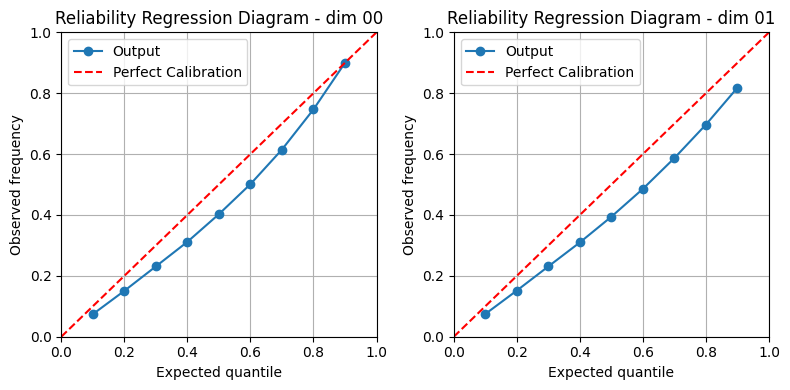

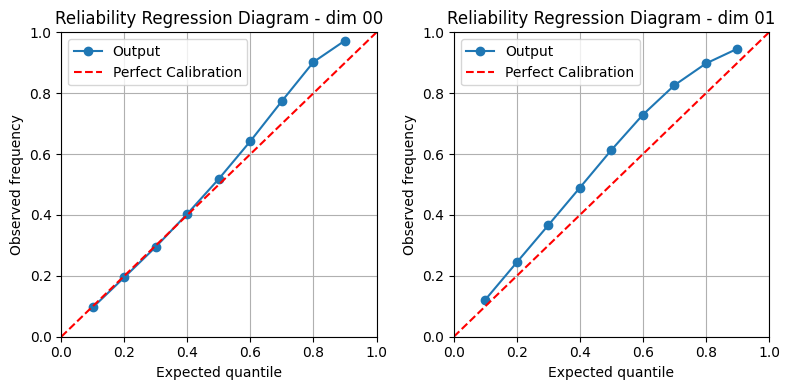

In [104]:
quantiles = np.linspace(0.1,0.9,9)
test_labels = true_labels[test_indices, :]
diagram = ReliabilityRegression(quantiles=quantiles)
plot = diagram.plot((test_means, test_stds), test_labels)
print(nll.measure((test_means, test_stds), test_labels, reduction="mean"))
print(qce.measure((test_means, test_stds), test_labels, q=quantiles, reduction="mean"))

plot = diagram.plot((test_means, stddev_gpnormal), test_labels)
print(nll.measure((test_means, stddev_gpnormal), test_labels, reduction="mean"))
print(qce.measure((test_means, stddev_gpnormal), test_labels, q=quantiles, reduction="mean"))

# Variance Scaling

It seems like so far this does not work very well to recalibrate the model.

5.42210489814221
0.0736909075224293
5.249334280175793
0.0535886818495514


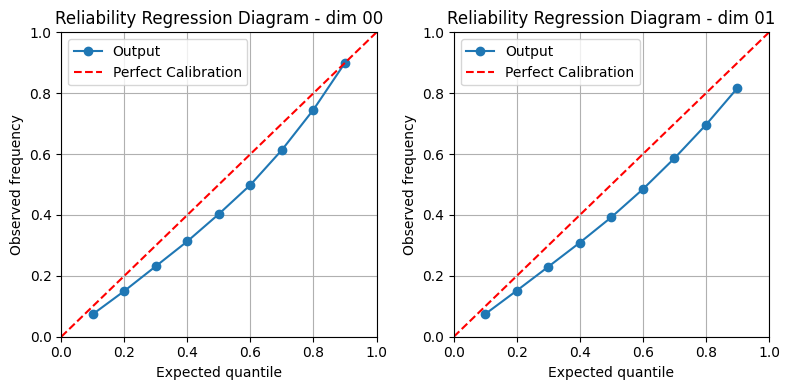

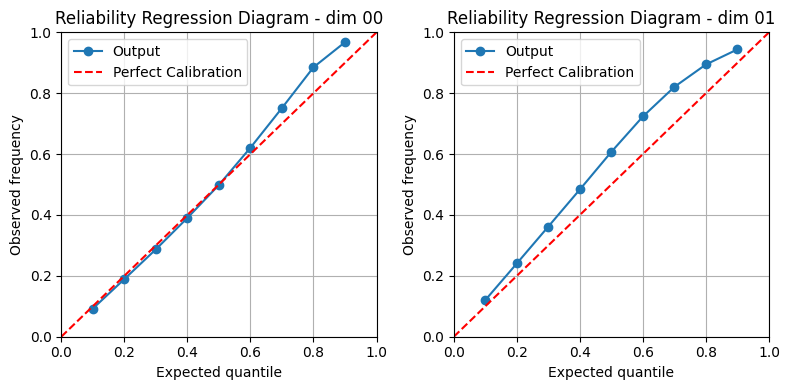

In [105]:
from netcal.regression import VarianceScaling

varscaling = VarianceScaling()

# Calculate the length of a third of your data
l = int(means.shape[0] / 3)

# Generate random unique indices for the training set
train_indices = np.random.choice(means.shape[0], l, replace=False)

# Create the training set
train_means = means[train_indices, :]
train_stds = stds[train_indices, :]
train_labels = true_labels[train_indices, :]

# Fit the model on the training set
varscaling.fit((train_means, train_stds), train_labels)

# Create indices for the testing set from the remaining data
test_indices = np.array([i for i in range(means.shape[0]) if i not in train_indices])

# Create the testing set
test_means = means[test_indices, :]
test_stds = stds[test_indices, :]

# Transform distributions to obtain recalibrated stddevs on the testing set
stddev_varscaling = varscaling.transform((test_means, test_stds))

quantiles = np.linspace(0.1,0.9,9)
test_labels = true_labels[test_indices, :]
diagram = ReliabilityRegression(quantiles=quantiles)
plot = diagram.plot((test_means, test_stds), test_labels)
print(nll.measure((test_means, test_stds), test_labels, reduction="mean"))
print(qce.measure((test_means, test_stds), test_labels, q=quantiles, reduction="mean"))

plot = diagram.plot((test_means, stddev_varscaling), test_labels)
print(nll.measure((test_means, stddev_varscaling), test_labels, reduction="mean"))
print(qce.measure((test_means, stddev_varscaling), test_labels, q=quantiles, reduction="mean"))

# Netcal Isotonic Regression

In [261]:

from typing import Union, List, Tuple, Optional
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from sklearn.isotonic import IsotonicRegression as sklearn_iso
from scipy.stats import norm
from matplotlib import pyplot as plt
from collections import defaultdict

from netcal import AbstractCalibration, cumulative, meanvar, density_from_cumulative


class IsotonicRegression(AbstractCalibration):
    """
    Isotonic regression calibration for probabilistic regression models with multiple independent
    output dimensions (optionally).
    Isotonic regression is a piecewise constant, monotonically increasing mapping function used to recalibrate
    the estimated cumulative density function (CDF) of a probabilistic forecaster [1]_. The goal of regression
    calibration using Isotonic regression is to achieve quantile calibration.

    On the one hand, this method accepts as input X either a tuple X = (mean, stddev) using two NumPy arrays of
    shape N with N number of samples that express the estimated mean and standard deviation of a probabilistic
    forecaster. On the other hand, a NumPy array of shape (R, N) is also accepted where R denotes the number of
    probabilistic forecasts. For example, if probabilistic outputs are obtained by Monte-Carlo sampling using N samples
    and R stochastic forward passes, it is possible to pass all outputs to the calibration function in a single
    NumPy array.

    This method is capable of multiple independent data dimensions where separate calibration models are fitted for
    each data dimension. This method outputs a tuple consisting of three NumPy arrays:

    - 1st array: T points where the density/cumulative distribution functions are defined, shape: (T, N, D)
    - 2nd array: calibrated probability density function, shape: (T, N, D)
    - 3rd array: calibrated cumulative density function, shape: (T, N, D)

    **Mathematical background:** In [1]_, regression calibration is defined in terms of *quantile calibration*.
    A probabilistic forecaster :math:`h(X)` outputs for any input :math:`X \\in \\mathbb{R}` a probability density
    distribution :math:`f_Y(y)` for the target domain :math:`Y \\in \\mathcal{Y} = \\mathbb{R}`. The according
    cumulative density function (CDF) is denoted as :math:`F_Y(y)`, the respective (inverse) quantile function
    :math:`F^{-1}_Y(\\tau)` for a certain confidence level :math:`\\tau \\in [0, 1]`. The quantile function denotes
    the quantile boundaries in :math:`\\mathcal{Y}` given a certain confidence level :math:`\\tau`.
    Using this notation, *quantile calibration* [1]_ is defined as

    .. math::
        \\mathbb{P}(Y \\leq F^{-1}_Y(\\tau)) = \\tau, \\quad \\forall \\tau \\in [0, 1] ,

    which is equivalent to

    .. math::
        \\mathbb{P}(F^{-1}_Y(\\tau_1) \\leq Y \\leq F^{-1}_Y(\\tau_2)) = \\tau_2 - \\tau_1,
        \\quad \\forall \\tau_1, \\tau_2 \\in [0, 1] .

    In other words, the estimated quantiles should match the observed quantiles. For example, if we inspect the 90%
    quantiles of a forecaster over multiple samples, we would expect that 90% of all ground-truth estimates fall into
    these quantiles.

    The Isotonic Regression consumes the input cumulative distribution function (CDF) and compares it with the
    empirical data CDF. With this comparison, it is possible to map the uncalibrated CDF estimates to calibrated
    ones using a monotonically increasing step function.

    References
    ----------
    .. [1] Volodymyr Kuleshov, Nathan Fenner, and Stefano Ermon:
       "Accurate uncertainties for deep learning using calibrated regression."
       International Conference on Machine Learning. PMLR, 2018.
       `Get source online <http://proceedings.mlr.press/v80/kuleshov18a/kuleshov18a.pdf>`__
    """

    def __init__(self):
        """ Constructor. """

        super().__init__(detection=False, independent_probabilities=False)
        self._iso = None

    def clear(self):
        """ Clear model parameters. """

        self._iso = None

    def fit(
            self,
            X: Union[List[np.ndarray], Tuple[np.ndarray, np.ndarray], np.ndarray],
            y: np.ndarray,
            tensorboard: Optional[SummaryWriter] = None
    ) -> 'IsotonicRegression':
        """
        Fit a isotonic regression calibration method to the provided data. If multiple dimensions are provided,
        multiple independent regression models are fitted for each dimension.

        Parameters
        ----------
        X : np.ndarray of shape (r, n, [d]) or Tuple of two np.ndarray, each of shape (n, [d])
            Input data for calibration regression obtained by a model that performs inference with uncertainty.
            Depending on the input format, this method handles the input differently:
            If X is tuple of two NumPy arrays with shape (n, [d]) for each array, this method asserts the
            first array as mean and the second one as the according stddev predictions with d dimensions (optionally).
            If X is single NumPy array of shape (r, n), this methods asserts predictions obtained by a stochastic
            inference model (e.g. network using MC dropout) with n samples and r stochastic forward passes. In this
            case, the mean and stddev is computed automatically.
        y : np.ndarray of shape (n, [d])
            Target scores for each prediction estimate in X.
        tensorboard: torch.utils.tensorboard.SummaryWriter, optional, default: None
            Instance of type "SummaryWriter" to log training statistics.

        Returns
        -------
        IsotonicRegression
            Instance of class :class:`netcal.regression.IsotonicRegression`.
        """

        # add a preceeding (sample) dimension to y as "cumulative" expects multiple points on the
        # cumulative in the first dimension
        y = np.expand_dims(y, axis=0)  # (1, n, [d])
        print("shape Y", y.shape, "should be: (1, n, [d])")
        cdf_predicted, y = cumulative(X, y)  # (1, n, d)

        # squeeze out the first data dim
        cdf_predicted = np.squeeze(cdf_predicted, axis=0)  # (n, d)
        print("cdf_predicted", cdf_predicted.shape, "should be: (n, d)")
        # rand = np.abs(np.random.normal(loc=0.0, scale=1e-, size=cdf_predicted.shape))
        # cdf_predicted = cdf_predicted + np.where(cdf_predicted > 0.99, -rand, rand)
        print("cdf_predicted", cdf_predicted.shape, "should be: (n, d)")
        n_samples, n_dims = cdf_predicted.shape

        # fit the isotonic regression for each dimension independently
        self._iso = []
        for dim in range(n_dims):
            iso = sklearn_iso(out_of_bounds='clip')

            cdf = np.sort(cdf_predicted[:, dim])  # Sort the predictor values
            cdf_empirical = np.linspace(1./n_samples, 1., n_samples)  # Create the empirical CDF

            # Group by unique values in cdf and calculate median of corresponding cdf_empirical values
            unique_cdf, indices = np.unique(cdf, return_inverse=True)
            median_cdf_empirical = np.array([np.median(cdf_empirical[indices == idx]) for idx in range(len(unique_cdf))])

            iso.fit(unique_cdf, median_cdf_empirical)
            self._iso.append(iso)
            # iso = sklearn_iso(out_of_bounds='clip')

            # # get the empirical cumulative for the current dim
            # # use sort algorithm to determine how many samples are less or equal given a certain sample
            # # simply use linspace to give the fraction of the relative amount of less or equal
            # # samples in a sorted array
            # cdf = np.sort(cdf_predicted[:, dim])  # (n,)
            # cdf_empirical = np.linspace(1./n_samples, 1., n_samples)  # (n,)

            # # this method might introduce a small error when consecutive samples have the same value
            # # in this case, identify equal samples and reassign the new cumulative score in reversed order
            # equal, = np.where(cdf[:-1] == cdf[1:])  # (n-1, )
            # for idx in reversed(equal):
            #     cdf_empirical[idx] = cdf_empirical[idx+1]

            # iso.fit(cdf, cdf_empirical)
            # self._iso.append(iso)

            # draw calibration curve for current dimension and add to SummaryWriter
            if tensorboard is not None:

                # draw matplotlib figure
                fig, ax = plt.subplots()
                ax.plot(iso.X_thresholds_, iso.y_thresholds_)
                ax.grid(True)
                ax.set_xlim([0., 1.])
                ax.set_ylim([0., 1.])
                ax.set_title("Isotonic recalibration curve dim %02d" % dim)

                # add matplotlib figure to SummaryWriter
                tensorboard.add_figure("isotonic/train/curve/dim%02d" % dim, fig, close=True)

        # add number of training samples to tensorboard
        if tensorboard is not None:
            tensorboard.add_scalar("isotonic/train/n_samples", n_samples)

        return self

    def transform(
            self,
            X: Union[List[np.ndarray], Tuple[np.ndarray, np.ndarray], np.ndarray],
            t: Union[int, np.ndarray] = 512
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Transform uncalibrated distributional estimates (mean and stddev or stochastic samples) to calibrated ones
        by applying isotonic regression calibration of quantiles. Use the parameter "t" to control the base points
        for the returned density/cumulative functions.

        Parameters
        ----------
        X : np.ndarray of shape (r, n, [d]) or Tuple of two np.ndarray, each of shape (n, [d])
            Input data for calibration regression obtained by a model that performs inference with uncertainty.
            Depending on the input format, this method handles the input differently:
            If X is tuple of two NumPy arrays with shape (n, [d]) for each array, this method asserts the
            first array as mean and the second one as the according stddev predictions with d dimensions (optionally).
            If X is single NumPy array of shape (r, n), this methods asserts predictions obtained by a stochastic
            inference model (e.g. network using MC dropout) with n samples and r stochastic forward passes. In this
            case, the mean and stddev is computed automatically.
        t : int or np.ndarray of shape (t, [n, [d]])
            Parameter to control the output sample distribution. If integer, the given amount of
            sample points for each input X is created. If np.ndarray, use this as distribution values for each
            sample and each dim in X at location t (either for all samples equally with shape (t,) or for each sample
            individually with shape (t, n, [d])).

        Returns
        -------
        tuple of 3 np.ndarray, each of shape (t, n, d)
            First array holds the points where the density and cumulative functions are defined, shape: (t, n ,d).
            Second array is the recalibrated probability density function (PDF), shape: (t, n, d).
            Third array is the recalibrated cumulative density function (CDF), shape: (t, n, d).
            Note that the data dimension d is always present (also for d=1).
        """

        # check if method has already been trained
        if self._iso is None:
            raise RuntimeError("IsotonicRegression: call \'fit()\' method first before transform.")

        # get number of dimension used for training
        n_dims = len(self._iso)
        mean, variance, cov = meanvar(X)

        # catch covariance input
        if cov:
            raise RuntimeError("IsotonicRegression: covariance input is currently not supported for quantile computation.")

        # make mean and variance at least 2d
        mean = np.expand_dims(mean, axis=1) if mean.ndim == 1 else mean  # (n, d)
        variance = np.expand_dims(variance, axis=1) if variance.ndim == 1 else variance  # (n, d)

        # initialize sampling points to define the recalibrated PDF/CDF
        n_samples = mean.shape[0]
        if isinstance(t, int):

            target_quantile = 1e-7
            stddev = np.sqrt(variance)

            # initialize empty boundaries for cumulative x-scores
            lb_cdf = np.zeros(len(self._iso))  # (d,)
            ub_cdf = np.zeros(len(self._iso))  # (d,)

            # iterate over all dimensions and examine the according isotonic regression model
            for dim, iso in enumerate(self._iso):

                # get the indices of the isotonic calibration curve where the desired relevance level is reached
                lb_idx = np.argmax(iso.y_thresholds_ >= target_quantile)
                ub_idx = len(iso.y_thresholds_) - np.argmax(np.flip(iso.y_thresholds_) < (1-target_quantile)) - 1

                # get the according x-scores of the (recalibrated) cumulative
                lb_cdf[dim] = iso.X_thresholds_[lb_idx] + (18e-3)
                ub_cdf[dim] = iso.X_thresholds_[ub_idx] - (18e-3)


            # finally, convert these scores back to the uncalibrated cumulative to obtain the sampling points
            # with boundaries for the uncalibrated cumulative
            print(lb_cdf[None, :])
            print(ub_cdf[None, :])


            lb = norm.ppf(lb_cdf[None, :], loc=mean, scale=stddev)  # (n, d)
            ub = norm.ppf(ub_cdf[None, :], loc=mean, scale=stddev)  # (n, d)

            print("lb", np.isnan(lb).any())
            print("ub", np.isnan(lb).any())

            sampling_points = np.linspace(lb, ub, t, axis=0)  # (t, n, d)


        # if t is np.ndarray, use this points as the base for the calibrated
        # output distribution
        elif isinstance(t, np.ndarray):

            # distribute 1d/2d array
            if t.ndim == 1:
                sampling_points = np.reshape(t, (-1, 1, 1))  # (t, 1, 1)
                sampling_points = np.broadcast_to(sampling_points, (t.shape[0], n_samples, n_dims))  # (t, n, d)

            elif t.ndim == 2:
                sampling_points = np.expand_dims(t, axis=2)  # (t, n, 1)
                sampling_points = np.broadcast_to(sampling_points, (t.shape[0], n_samples, n_dims))  # (t, n, d)

            elif t.ndim == 3:
                sampling_points = t  # (t, n, d)

            else:
                raise RuntimeError("Invalid shape for parameter \'t\'.")

            # guarantee monotonically increasing sampling points (required for PDF diff)
            sampling_points = np.sort(sampling_points, axis=0)  # (t, n, d)
        else:
            raise AttributeError("Parameter \'t\' must be either of type int or np.ndarray.")

        t = sampling_points.shape[0]
        print("X", np.isnan(X).any())
        print("sampling points", np.isnan(sampling_points).any())
        cdf, _ = cumulative(X, sampling_points)  # (t, n, d)
        print(np.isnan(cdf).any())
        print(np.isnan(t).any())

        # iterate over dimensions and perform recalibration of the cumulative
        for dim in range(n_dims):
            # print(np.isnan(self._iso[dim].transform(cdf[..., dim].flatten())).any())
            # print(np.isnan(np.finfo(np.float32).eps).any())
            # print(np.isnan(cdf[..., dim].flatten()).any())
            cdf[..., dim] = np.clip(
                self._iso[dim].transform(cdf[..., dim].flatten()),  # (t*n,)
                np.finfo(np.float32).eps,
                1.-np.finfo(np.float32).eps
            ).reshape((t, n_samples))  # (t, n)

        # get density function using the cumulative
        pdf = density_from_cumulative(sampling_points, cdf)

        return sampling_points, pdf, cdf

    def __repr__(self):
        """ Returns a string representation of the calibration method with the most important parameters. """

        if self._iso is None:
            return "IsotonicRegression(fitted=False)"
        else:
            return "IsotonicRegression(fitted=True)"

In [262]:
isotonic = IsotonicRegression()

# Calculate the length of a third of your data
l = int(means.shape[0] / 2)

# Generate random unique indices for the training set
train_indices = np.random.choice(means.shape[0], l, replace=False)

# Create the training set
train_labels = true_labels[train_indices, :]
train_stacked = stacked.reshape(100,-1, 2)[:,train_indices,:]

# Fit the model on the training set
isotonic.fit(train_stacked, train_labels)


# Create indices for the testing set from the remaining data
test_indices = np.array([i for i in range(means.shape[0]) if i not in train_indices])

# Create the testing set
test_stacked = stacked.reshape(100,-1, 2)[:,test_indices,:]
test_labels = true_labels[test_indices,:]


t_isotonic, pdf_isotonic, cdf_isotonic = isotonic.transform(test_stacked, t=1000)



shape Y (1, 38640, 2) should be: (1, n, [d])
cdf_predicted (38640, 2) should be: (n, d)
cdf_predicted (38640, 2) should be: (n, d)
[[0.018 0.018]]
[[0.982 0.982]]
lb False
ub False
X False
sampling points False
False
False


5.406274095530175
0.0823556475730389
5.282431679638873
0.037778927996319295


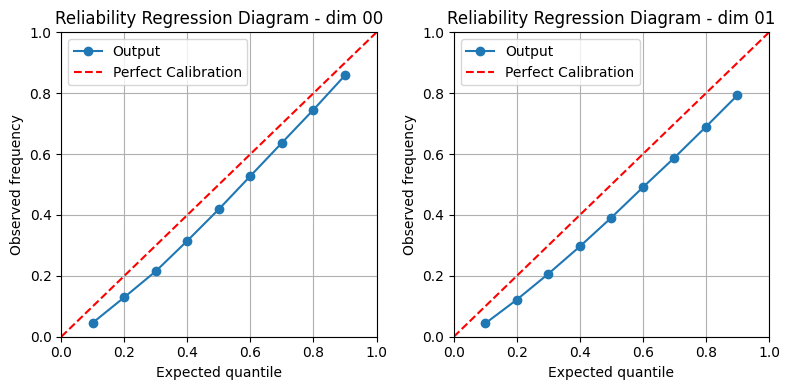

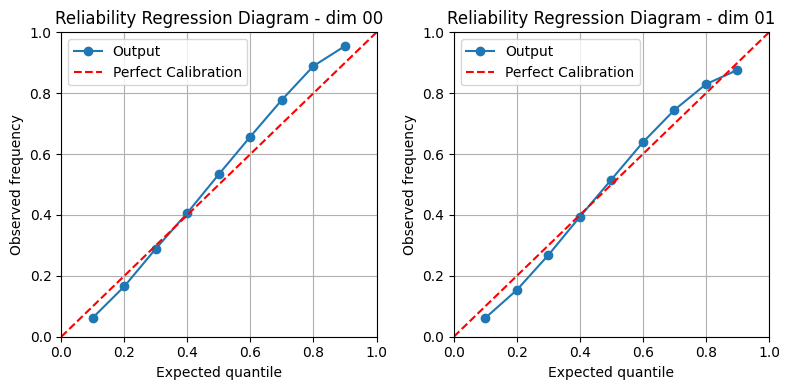

In [263]:
quantiles = np.linspace(0.1,0.9,9)
diagram = ReliabilityRegression(quantiles=quantiles)
plot = diagram.plot(test_stacked, test_labels)
print(nll.measure(test_stacked, test_labels, reduction="mean"))
print(qce.measure(test_stacked, test_labels, q=quantiles, reduction="mean"))

plot = diagram.plot(t_isotonic, test_labels)
print(nll.measure(t_isotonic, test_labels, reduction="mean"))
print(qce.measure(t_isotonic, test_labels, q=quantiles, reduction="mean"))

(100, 38640, 2)

# Implementation of Isotonic Recalibration

In [96]:
print(stacked.shape)
print(true_labels.shape)

P_preds_train = stacked[:50,:,1].reshape(77280,-1)
P_preds_test = stacked[50:,:,1].reshape(77280,-1)
P_labels = true_labels[:,1].reshape(77280,1)
print(P_preds_test.shape)
print(P_labels.shape)

(100, 77280, 2)
(77280, 2)
(77280, 50)
(77280, 1)


In [97]:
def calculate_quantiles(samples, y):
    return np.sum(samples <= y, axis=1) / samples.shape[1]

def make_cal_dataset(samples, y):
    
    T = y.shape[0]

    quant_y = calculate_quantiles(samples, y)

    print(quant_y.shape)

    # p_hat.shape = (T,)
    p_hat = calculate_quantiles(quant_y.reshape(-1, T),
                                quant_y.reshape(T, -1))

    return(quant_y, p_hat)

In [98]:
calculate_quantiles(samples= P_preds_train, y = P_labels)

array([0.58, 0.88, 0.8 , ..., 0.06, 0.92, 0.98])

In [99]:
predict, empiric = make_cal_dataset(samples= P_preds_train, y = P_labels)

(77280,)


Text(0.5, 1.0, 'Calibration Dataset')

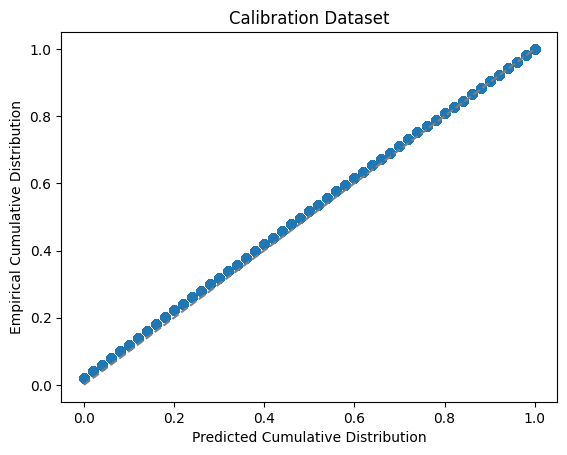

In [100]:
plt.scatter(predict, empiric)
plt.plot([0, 1], [0, 1], color='tab:grey', linestyle='--')
plt.xlabel('Predicted Cumulative Distribution')
plt.ylabel('Empirical Cumulative Distribution')
plt.title('Calibration Dataset')

In [101]:
import warnings

import numpy as np
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt

ir = IsotonicRegression(out_of_bounds='clip')
ir.fit(empiric, predict)


IsotonicRegression(out_of_bounds='clip')

In [102]:
print(empiric)

[0.59601449 0.88368271 0.80881211 ... 0.08003364 0.92277433 0.9811853 ]


In [103]:
print(predict)

[0.58 0.88 0.8  ... 0.06 0.92 0.98]


In [104]:
test = calculate_quantiles(P_preds_test, P_labels)

[0.         0.01979454 0.04022733 0.05996679 0.0800262  0.10025638
 0.11949222 0.13937927 0.15897845 0.17810878 0.19831164 0.2187833
 0.23912895 0.25928814 0.27986676 0.30075116 0.32125594 0.34158678
 0.36129178 0.38177049 0.40203798 0.42229815 0.44258629 0.46227261
 0.48260108 0.50330649 0.52342368 0.54369728 0.56374787 0.58419333
 0.60544759 0.62664359 0.64693462 0.66798394 0.68815094 0.70793688
 0.72827123 0.74896986 0.76981312 0.79065844 0.81190909 0.8333454
 0.85477924 0.87608259 0.89672414 0.9171659  0.93726589 0.95819768
 0.97878272 1.        ]
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


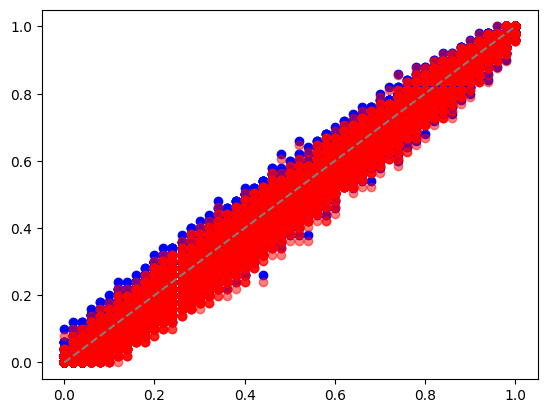

In [105]:
plt.scatter(predict, test, color='b')
plt.scatter(predict, ir.predict(test), alpha=0.5, color='r')
plt.plot([0, 1], [0, 1], color='tab:grey', linestyle='--')
print(np.unique(ir.predict(predict)))
print(np.unique(predict))

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

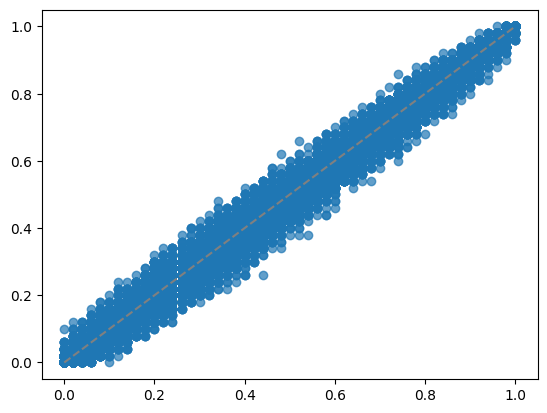

In [106]:
plt.scatter(predict, test, alpha=0.7)
plt.plot([0,1],[0,1],'--', color='grey', label='Perfect calibration')
plt.set_xlabel('Predicted', fontsize=17)
plt.set_ylabel('Empirical', fontsize=17)
plt.set_title('Predicted CDF vs Empirical CDF', fontsize=17)
plt.legend(fontsize=17)

Text(0, 0.5, 'Observed Confidence Level')

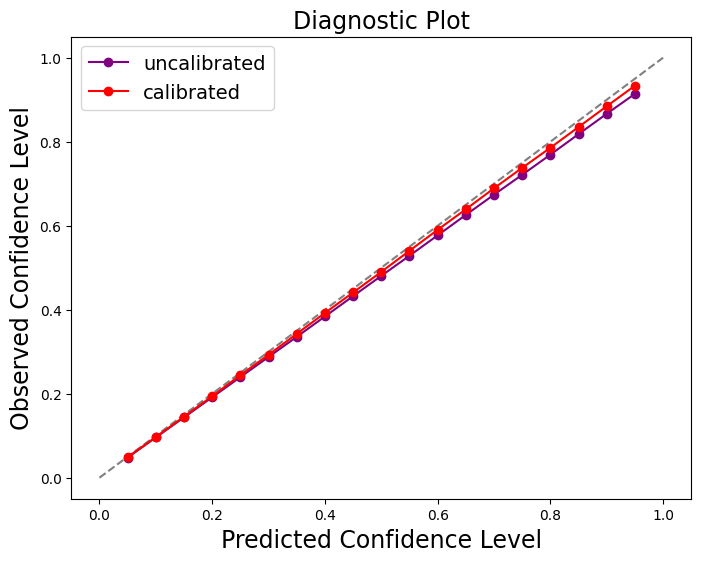

In [110]:
fig, ax = plt.subplots(figsize=(8, 6))

conf_level_lower_bounds = np.arange(start=0.025, stop=0.5, step=0.025)
conf_levels = 1-2*conf_level_lower_bounds
unc_pcts = []
cal_pcts = []

for cl_lower in conf_level_lower_bounds:
    quants = [cl_lower, 1-cl_lower]
    new_quantiles = ir.predict(quants)
    post_pred_test = P_preds_test
    # post_pred_test, new_quantiles = self.predict(X_test, y_test, quants)

    cal_lower, cal_upper = np.quantile(post_pred_test, new_quantiles, axis=1)
    unc_lower, unc_upper = np.quantile(post_pred_test, quants, axis=1)

    perc_within_unc = np.mean((P_labels <= unc_upper)&(P_labels >= unc_lower))
    perc_within_cal = np.mean((P_labels <= cal_upper)&(P_labels >= cal_lower))

    unc_pcts.append(perc_within_unc)
    cal_pcts.append(perc_within_cal)

ax.plot([0,1],[0,1],'--', color='grey')
ax.plot(conf_levels, unc_pcts, '-o', color='purple', label='uncalibrated')
ax.plot(conf_levels, cal_pcts, '-o', color='red', label='calibrated')
ax.legend(fontsize=14)
ax.set_title('Diagnostic Plot', fontsize=17)
ax.set_xlabel('Predicted Confidence Level', fontsize=17)
ax.set_ylabel('Observed Confidence Level', fontsize=17)